In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [5]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [6]:
df = pd.read_csv("Tetuan City power consumption.csv")

In [7]:
from datetime import datetime

In [8]:
#Converting object to datetime datatype

df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') 

In [9]:
#transforming DateTime column into index
df = df.set_index('DateTime')

In [10]:
del df["Zone 2  Power Consumption"]


In [11]:
del df["Zone 3  Power Consumption"]

In [12]:
df

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
DateTime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620
...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452


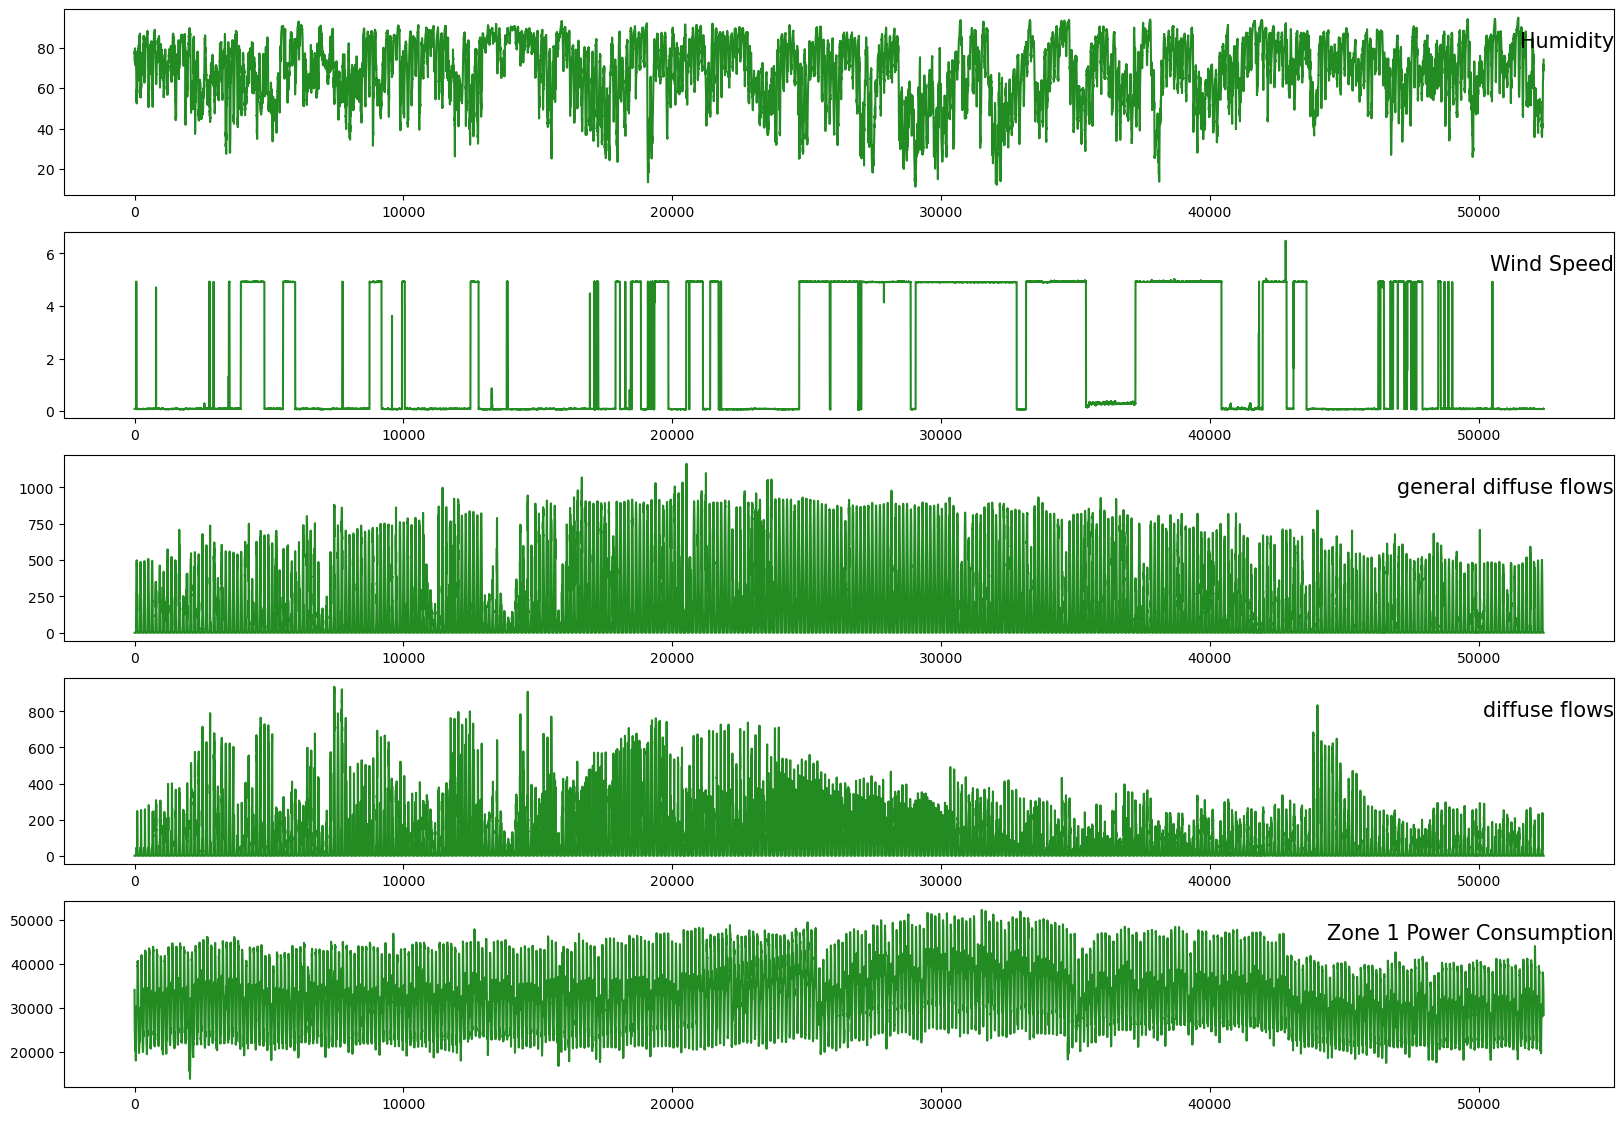

In [13]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

In [14]:
# Scaling the entire dataset

dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [15]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(52415, 12)


In [16]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)'],
      dtype='object')

In [17]:
len(reframed.columns)

12

In [18]:
# droping columns we don't want to predict

reframed.drop(reframed.columns[[6, 7, 8, 9, 10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var6(t)
1   0.090091   0.748382   0.005130   0.000040   0.000115   0.526251  0.415545
2   0.086146   0.756770   0.005130   0.000057   0.000079   0.415545  0.397623
3   0.083399   0.756770   0.004663   0.000050   0.000095   0.397623  0.374149
4   0.078176   0.762761   0.005130   0.000075   0.000091   0.374149  0.350834
5   0.072736   0.771148   0.004819   0.000038   0.000079   0.350834  0.332277


### Splitting the training data given into training and testing data for now.

In [19]:
values = reframed.values

# chia theo phut trong nam 2017 va lay 80% de train 20% test
n_train_minutes = 41932

train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(41932, 1, 6) (41932,) (10483, 1, 6) (10483,)


# Hai lớp LSTM không có drop out

In [66]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/500
1119/1119 - 4s - loss: 0.0079 - val_loss: 4.6698e-04 - 4s/epoch - 4ms/step
Epoch 2/500
1119/1119 - 2s - loss: 3.2604e-04 - val_loss: 4.4372e-04 - 2s/epoch - 2ms/step
Epoch 3/500
1119/1119 - 2s - loss: 3.0692e-04 - val_loss: 4.3298e-04 - 2s/epoch - 2ms/step
Epoch 4/500
1119/1119 - 2s - loss: 3.2422e-04 - val_loss: 4.8186e-04 - 2s/epoch - 2ms/step
Epoch 5/500
1119/1119 - 2s - loss: 3.0619e-04 - val_loss: 4.0846e-04 - 2s/epoch - 2ms/step
Epoch 6/500
1119/1119 - 2s - loss: 3.0220e-04 - val_loss: 3.9480e-04 - 2s/epoch - 2ms/step
Epoch 7/500
1119/1119 - 2s - loss: 2.9472e-04 - val_loss: 3.6845e-04 - 2s/epoch - 2ms/step
Epoch 8/500
1119/1119 - 2s - loss: 2.9020e-04 - val_loss: 3.5126e-04 - 2s/epoch - 2ms/step
Epoch 9/500
1119/1119 - 2s - loss: 2.8600e-04 - val_loss: 3.3574e-04 - 2s/epoch - 2ms/step
Epoch 10/500
1119/1119 - 2s - loss: 2.8297e-04 - val_loss: 3.2465e-04 - 2s/epoch - 2ms/step
Epoch 11/500
1119/1119 - 2s - loss: 2.8052e-04 - val_loss: 3.1614e-04 - 2s/epoch - 2ms/step
E

Epoch 91/500
1119/1119 - 2s - loss: 2.0693e-04 - val_loss: 1.8501e-04 - 2s/epoch - 2ms/step
Epoch 92/500
1119/1119 - 2s - loss: 2.0659e-04 - val_loss: 1.8469e-04 - 2s/epoch - 2ms/step
Epoch 93/500
1119/1119 - 2s - loss: 2.0625e-04 - val_loss: 1.8436e-04 - 2s/epoch - 2ms/step
Epoch 94/500
1119/1119 - 2s - loss: 2.0591e-04 - val_loss: 1.8401e-04 - 2s/epoch - 2ms/step
Epoch 95/500
1119/1119 - 2s - loss: 2.0557e-04 - val_loss: 1.8364e-04 - 2s/epoch - 2ms/step
Epoch 96/500
1119/1119 - 2s - loss: 2.0524e-04 - val_loss: 1.8325e-04 - 2s/epoch - 2ms/step
Epoch 97/500
1119/1119 - 2s - loss: 2.0490e-04 - val_loss: 1.8283e-04 - 2s/epoch - 2ms/step
Epoch 98/500
1119/1119 - 2s - loss: 2.0456e-04 - val_loss: 1.8240e-04 - 2s/epoch - 2ms/step
Epoch 99/500
1119/1119 - 2s - loss: 2.0422e-04 - val_loss: 1.8196e-04 - 2s/epoch - 2ms/step
Epoch 100/500
1119/1119 - 2s - loss: 2.0388e-04 - val_loss: 1.8150e-04 - 2s/epoch - 2ms/step
Epoch 101/500
1119/1119 - 2s - loss: 2.0354e-04 - val_loss: 1.8105e-04 - 2s/epo

Epoch 180/500
1119/1119 - 2s - loss: 1.9215e-04 - val_loss: 1.7992e-04 - 2s/epoch - 2ms/step
Epoch 181/500
1119/1119 - 2s - loss: 1.9208e-04 - val_loss: 1.8005e-04 - 2s/epoch - 2ms/step
Epoch 182/500
1119/1119 - 2s - loss: 1.9201e-04 - val_loss: 1.8017e-04 - 2s/epoch - 2ms/step
Epoch 183/500
1119/1119 - 2s - loss: 1.9195e-04 - val_loss: 1.8029e-04 - 2s/epoch - 2ms/step
Epoch 184/500
1119/1119 - 2s - loss: 1.9189e-04 - val_loss: 1.8039e-04 - 2s/epoch - 2ms/step
Epoch 185/500
1119/1119 - 2s - loss: 1.9182e-04 - val_loss: 1.8048e-04 - 2s/epoch - 2ms/step
Epoch 186/500
1119/1119 - 2s - loss: 1.9176e-04 - val_loss: 1.8056e-04 - 2s/epoch - 2ms/step
Epoch 187/500
1119/1119 - 2s - loss: 1.9171e-04 - val_loss: 1.8062e-04 - 2s/epoch - 2ms/step
Epoch 188/500
1119/1119 - 2s - loss: 1.9165e-04 - val_loss: 1.8067e-04 - 2s/epoch - 2ms/step
Epoch 189/500
1119/1119 - 2s - loss: 1.9159e-04 - val_loss: 1.8070e-04 - 2s/epoch - 2ms/step
Epoch 190/500
1119/1119 - 2s - loss: 1.9154e-04 - val_loss: 1.8072e-04

1119/1119 - 2s - loss: 1.8728e-04 - val_loss: 1.7023e-04 - 2s/epoch - 2ms/step
Epoch 269/500
1119/1119 - 2s - loss: 1.8722e-04 - val_loss: 1.7017e-04 - 2s/epoch - 2ms/step
Epoch 270/500
1119/1119 - 2s - loss: 1.8715e-04 - val_loss: 1.7012e-04 - 2s/epoch - 2ms/step
Epoch 271/500
1119/1119 - 2s - loss: 1.8708e-04 - val_loss: 1.7006e-04 - 2s/epoch - 2ms/step
Epoch 272/500
1119/1119 - 2s - loss: 1.8701e-04 - val_loss: 1.7002e-04 - 2s/epoch - 2ms/step
Epoch 273/500
1119/1119 - 2s - loss: 1.8694e-04 - val_loss: 1.6997e-04 - 2s/epoch - 2ms/step
Epoch 274/500
1119/1119 - 2s - loss: 1.8687e-04 - val_loss: 1.6992e-04 - 2s/epoch - 2ms/step
Epoch 275/500
1119/1119 - 2s - loss: 1.8680e-04 - val_loss: 1.6988e-04 - 2s/epoch - 2ms/step
Epoch 276/500
1119/1119 - 2s - loss: 1.8673e-04 - val_loss: 1.6984e-04 - 2s/epoch - 2ms/step
Epoch 277/500
1119/1119 - 2s - loss: 1.8666e-04 - val_loss: 1.6980e-04 - 2s/epoch - 2ms/step
Epoch 278/500
1119/1119 - 2s - loss: 1.8659e-04 - val_loss: 1.6976e-04 - 2s/epoch - 

Epoch 357/500
1119/1119 - 2s - loss: 1.7985e-04 - val_loss: 1.6732e-04 - 2s/epoch - 2ms/step
Epoch 358/500
1119/1119 - 2s - loss: 1.7977e-04 - val_loss: 1.6724e-04 - 2s/epoch - 2ms/step
Epoch 359/500
1119/1119 - 2s - loss: 1.7968e-04 - val_loss: 1.6716e-04 - 2s/epoch - 2ms/step
Epoch 360/500
1119/1119 - 2s - loss: 1.7960e-04 - val_loss: 1.6708e-04 - 2s/epoch - 2ms/step
Epoch 361/500
1119/1119 - 2s - loss: 1.7951e-04 - val_loss: 1.6699e-04 - 2s/epoch - 2ms/step
Epoch 362/500
1119/1119 - 2s - loss: 1.7943e-04 - val_loss: 1.6691e-04 - 2s/epoch - 2ms/step
Epoch 363/500
1119/1119 - 2s - loss: 1.7935e-04 - val_loss: 1.6682e-04 - 2s/epoch - 2ms/step
Epoch 364/500
1119/1119 - 2s - loss: 1.7927e-04 - val_loss: 1.6674e-04 - 2s/epoch - 2ms/step
Epoch 365/500
1119/1119 - 2s - loss: 1.7918e-04 - val_loss: 1.6665e-04 - 2s/epoch - 2ms/step
Epoch 366/500
1119/1119 - 2s - loss: 1.7910e-04 - val_loss: 1.6657e-04 - 2s/epoch - 2ms/step
Epoch 367/500
1119/1119 - 2s - loss: 1.7902e-04 - val_loss: 1.6648e-04

1119/1119 - 2s - loss: 1.7419e-04 - val_loss: 1.6200e-04 - 2s/epoch - 2ms/step
Epoch 446/500
1119/1119 - 2s - loss: 1.7414e-04 - val_loss: 1.6198e-04 - 2s/epoch - 2ms/step
Epoch 447/500
1119/1119 - 2s - loss: 1.7409e-04 - val_loss: 1.6197e-04 - 2s/epoch - 2ms/step
Epoch 448/500
1119/1119 - 2s - loss: 1.7404e-04 - val_loss: 1.6195e-04 - 2s/epoch - 2ms/step
Epoch 449/500
1119/1119 - 2s - loss: 1.7399e-04 - val_loss: 1.6194e-04 - 2s/epoch - 2ms/step
Epoch 450/500
1119/1119 - 2s - loss: 1.7394e-04 - val_loss: 1.6193e-04 - 2s/epoch - 2ms/step
Epoch 451/500
1119/1119 - 2s - loss: 1.7389e-04 - val_loss: 1.6192e-04 - 2s/epoch - 2ms/step
Epoch 452/500
1119/1119 - 2s - loss: 1.7384e-04 - val_loss: 1.6191e-04 - 2s/epoch - 2ms/step
Epoch 453/500
1119/1119 - 2s - loss: 1.7379e-04 - val_loss: 1.6190e-04 - 2s/epoch - 2ms/step
Epoch 454/500
1119/1119 - 2s - loss: 1.7374e-04 - val_loss: 1.6189e-04 - 2s/epoch - 2ms/step
Epoch 455/500
1119/1119 - 2s - loss: 1.7370e-04 - val_loss: 1.6188e-04 - 2s/epoch - 

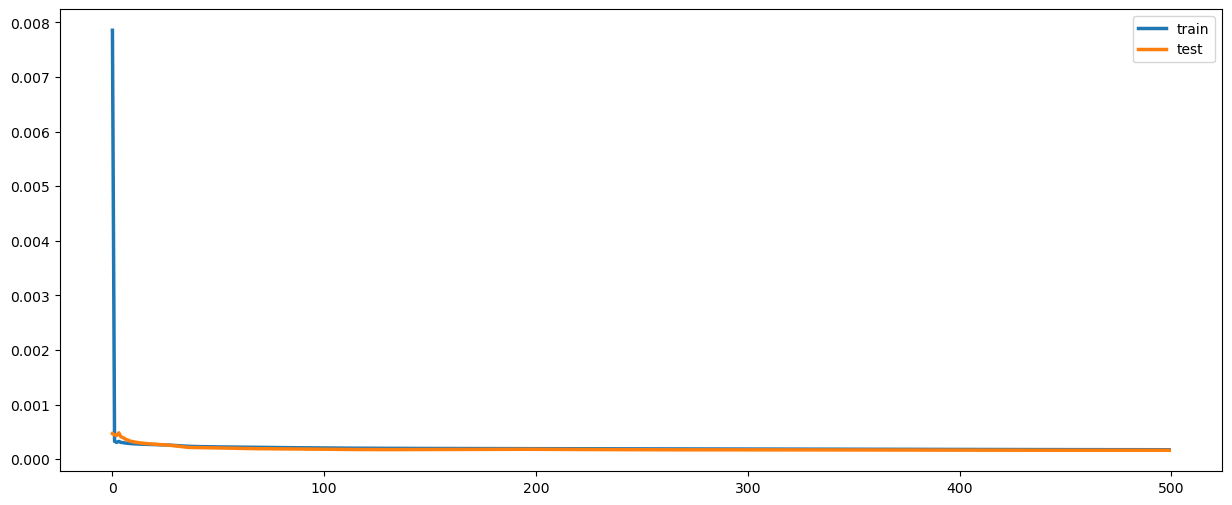

In [67]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [68]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 724us/step


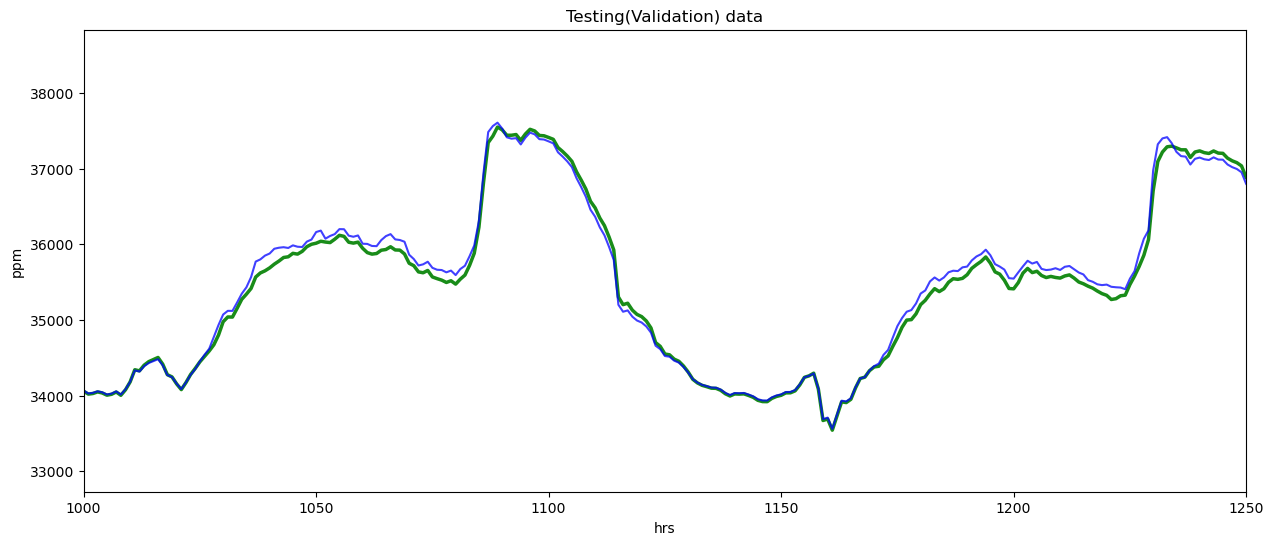

In [69]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [70]:
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 106.962555


In [71]:
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

MAPE: 0.23722073528915644 %


## 2 lớp không có dropout nhưng số lượng epochs = 100

In [72]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 4s - loss: 0.0075 - val_loss: 4.0883e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1119/1119 - 2s - loss: 3.2630e-04 - val_loss: 3.7460e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1119/1119 - 2s - loss: 3.1097e-04 - val_loss: 4.1840e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1119/1119 - 2s - loss: 3.2357e-04 - val_loss: 4.5098e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1119/1119 - 2s - loss: 3.0663e-04 - val_loss: 3.9388e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1119/1119 - 2s - loss: 3.0307e-04 - val_loss: 3.7854e-04 - 2s/epoch - 2ms/step
Epoch 7/100
1119/1119 - 2s - loss: 2.9596e-04 - val_loss: 3.5471e-04 - 2s/epoch - 2ms/step
Epoch 8/100
1119/1119 - 2s - loss: 2.9173e-04 - val_loss: 3.3888e-04 - 2s/epoch - 2ms/step
Epoch 9/100
1119/1119 - 2s - loss: 2.8775e-04 - val_loss: 3.2404e-04 - 2s/epoch - 2ms/step
Epoch 10/100
1119/1119 - 2s - loss: 2.8470e-04 - val_loss: 3.1228e-04 - 2s/epoch - 2ms/step
Epoch 11/100
1119/1119 - 2s - loss: 2.8198e-04 - val_loss: 3.0293e-04 - 2s/epoch - 2ms/step
E

Epoch 91/100
1119/1119 - 2s - loss: 2.0713e-04 - val_loss: 1.9085e-04 - 2s/epoch - 2ms/step
Epoch 92/100
1119/1119 - 2s - loss: 2.0677e-04 - val_loss: 1.9050e-04 - 2s/epoch - 2ms/step
Epoch 93/100
1119/1119 - 2s - loss: 2.0641e-04 - val_loss: 1.9014e-04 - 2s/epoch - 2ms/step
Epoch 94/100
1119/1119 - 2s - loss: 2.0606e-04 - val_loss: 1.8977e-04 - 2s/epoch - 2ms/step
Epoch 95/100
1119/1119 - 2s - loss: 2.0572e-04 - val_loss: 1.8938e-04 - 2s/epoch - 2ms/step
Epoch 96/100
1119/1119 - 2s - loss: 2.0539e-04 - val_loss: 1.8898e-04 - 2s/epoch - 2ms/step
Epoch 97/100
1119/1119 - 2s - loss: 2.0507e-04 - val_loss: 1.8857e-04 - 2s/epoch - 2ms/step
Epoch 98/100
1119/1119 - 2s - loss: 2.0475e-04 - val_loss: 1.8815e-04 - 2s/epoch - 2ms/step
Epoch 99/100
1119/1119 - 2s - loss: 2.0445e-04 - val_loss: 1.8771e-04 - 2s/epoch - 2ms/step
Epoch 100/100
1119/1119 - 2s - loss: 2.0415e-04 - val_loss: 1.8727e-04 - 2s/epoch - 2ms/step


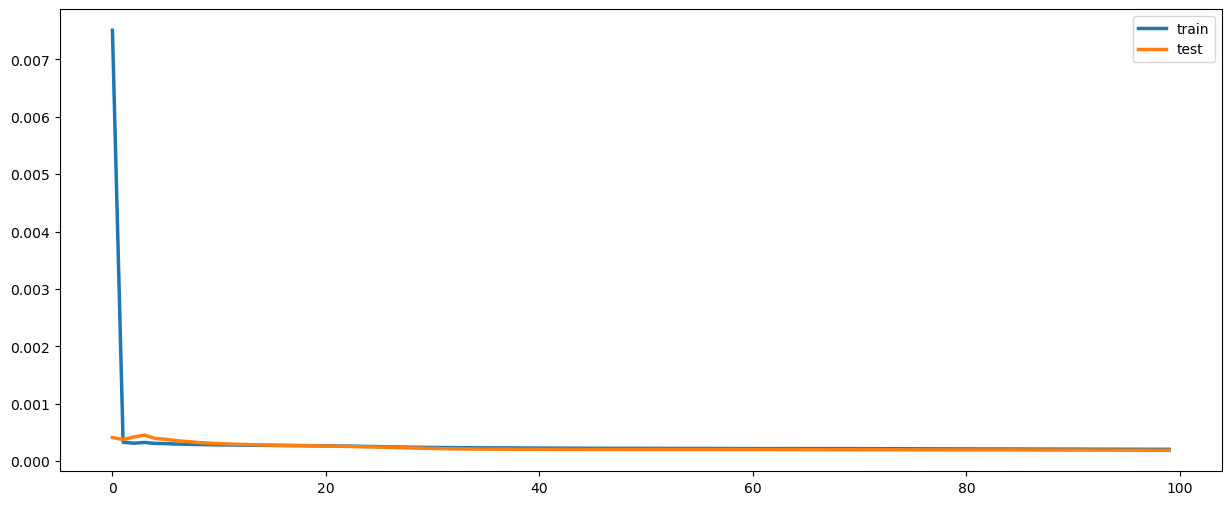

In [73]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [74]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 716us/step


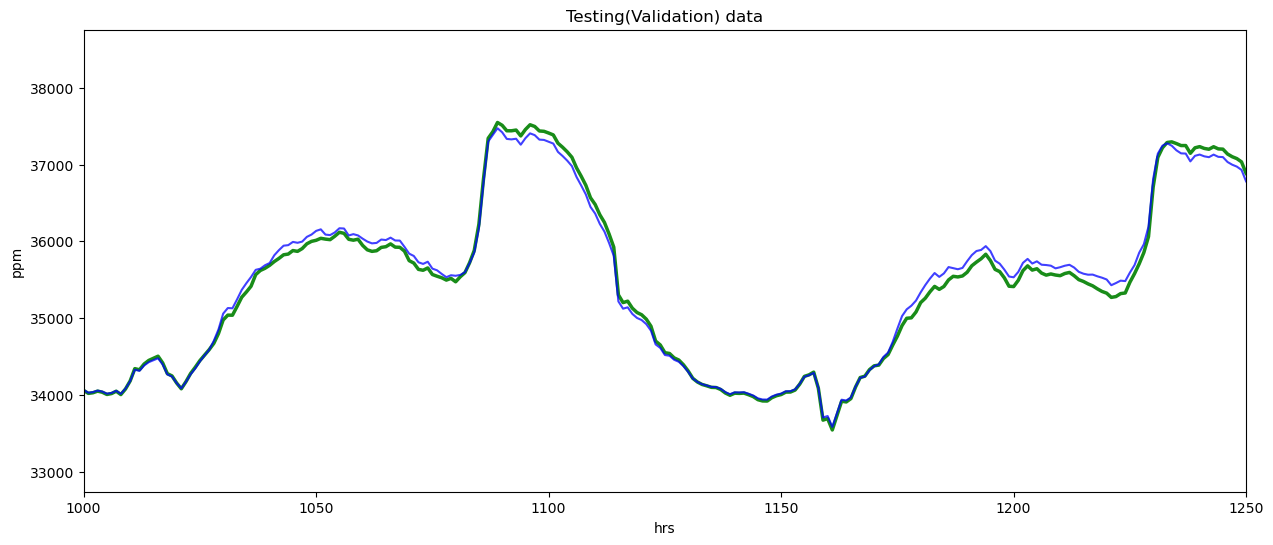

In [75]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [76]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 90.8456
MAPE: 0.22044191136956215 %


## 2 lớp không có dropout nhưng số lượng epochs = 50

In [77]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
1119/1119 - 4s - loss: 0.0074 - val_loss: 3.8750e-04 - 4s/epoch - 4ms/step
Epoch 2/50
1119/1119 - 2s - loss: 3.1205e-04 - val_loss: 3.7309e-04 - 2s/epoch - 2ms/step
Epoch 3/50
1119/1119 - 2s - loss: 3.2565e-04 - val_loss: 5.0040e-04 - 2s/epoch - 2ms/step
Epoch 4/50
1119/1119 - 2s - loss: 3.2491e-04 - val_loss: 4.6649e-04 - 2s/epoch - 2ms/step
Epoch 5/50
1119/1119 - 2s - loss: 3.1621e-04 - val_loss: 4.2966e-04 - 2s/epoch - 2ms/step
Epoch 6/50
1119/1119 - 2s - loss: 3.0901e-04 - val_loss: 4.0447e-04 - 2s/epoch - 2ms/step
Epoch 7/50
1119/1119 - 2s - loss: 3.0246e-04 - val_loss: 3.8103e-04 - 2s/epoch - 2ms/step
Epoch 8/50
1119/1119 - 2s - loss: 2.9724e-04 - val_loss: 3.6195e-04 - 2s/epoch - 2ms/step
Epoch 9/50
1119/1119 - 2s - loss: 2.9284e-04 - val_loss: 3.4599e-04 - 2s/epoch - 2ms/step
Epoch 10/50
1119/1119 - 2s - loss: 2.8923e-04 - val_loss: 3.3274e-04 - 2s/epoch - 2ms/step
Epoch 11/50
1119/1119 - 2s - loss: 2.8610e-04 - val_loss: 3.2133e-04 - 2s/epoch - 2ms/step
Epoch 12/50


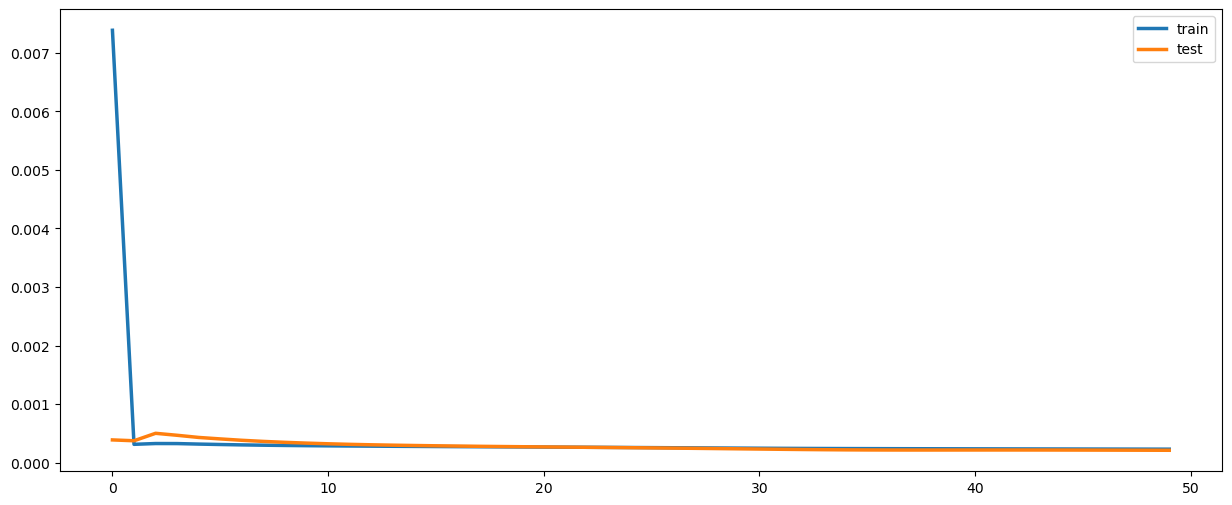

In [78]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [79]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 749us/step


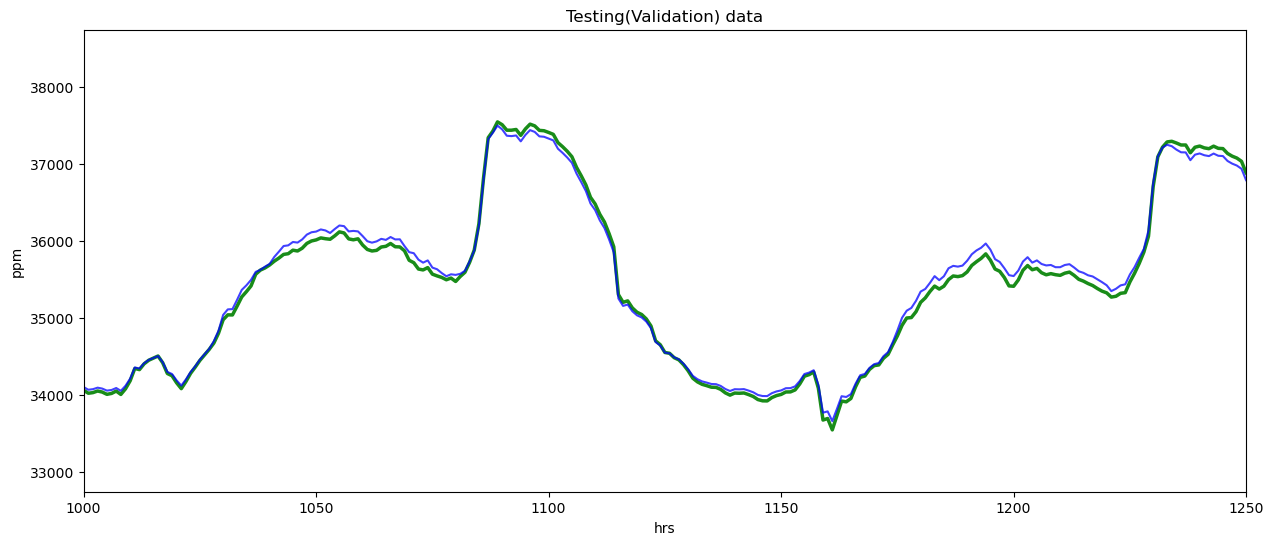

In [80]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [81]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 94.481735
MAPE: 0.24317800998687744 %


## 2 lớp không có dropout nhưng số lượng epochs = 150

In [82]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/150
1119/1119 - 4s - loss: 0.0076 - val_loss: 4.5399e-04 - 4s/epoch - 4ms/step
Epoch 2/150
1119/1119 - 2s - loss: 3.5514e-04 - val_loss: 4.2706e-04 - 2s/epoch - 2ms/step
Epoch 3/150
1119/1119 - 2s - loss: 3.2524e-04 - val_loss: 4.0920e-04 - 2s/epoch - 2ms/step
Epoch 4/150
1119/1119 - 2s - loss: 3.2091e-04 - val_loss: 4.1022e-04 - 2s/epoch - 2ms/step
Epoch 5/150
1119/1119 - 2s - loss: 3.1610e-04 - val_loss: 3.9581e-04 - 2s/epoch - 2ms/step
Epoch 6/150
1119/1119 - 2s - loss: 3.0405e-04 - val_loss: 3.6521e-04 - 2s/epoch - 2ms/step
Epoch 7/150
1119/1119 - 2s - loss: 2.9778e-04 - val_loss: 3.4833e-04 - 2s/epoch - 2ms/step
Epoch 8/150
1119/1119 - 2s - loss: 2.9213e-04 - val_loss: 3.3089e-04 - 2s/epoch - 2ms/step
Epoch 9/150
1119/1119 - 2s - loss: 2.8826e-04 - val_loss: 3.1821e-04 - 2s/epoch - 2ms/step
Epoch 10/150
1119/1119 - 2s - loss: 2.8500e-04 - val_loss: 3.0831e-04 - 2s/epoch - 2ms/step
Epoch 11/150
1119/1119 - 2s - loss: 2.8233e-04 - val_loss: 3.0053e-04 - 2s/epoch - 2ms/step
E

Epoch 91/150
1119/1119 - 2s - loss: 2.0993e-04 - val_loss: 1.8912e-04 - 2s/epoch - 2ms/step
Epoch 92/150
1119/1119 - 2s - loss: 2.0946e-04 - val_loss: 1.8869e-04 - 2s/epoch - 2ms/step
Epoch 93/150
1119/1119 - 2s - loss: 2.0900e-04 - val_loss: 1.8826e-04 - 2s/epoch - 2ms/step
Epoch 94/150
1119/1119 - 2s - loss: 2.0853e-04 - val_loss: 1.8782e-04 - 2s/epoch - 2ms/step
Epoch 95/150
1119/1119 - 2s - loss: 2.0807e-04 - val_loss: 1.8737e-04 - 2s/epoch - 2ms/step
Epoch 96/150
1119/1119 - 2s - loss: 2.0761e-04 - val_loss: 1.8692e-04 - 2s/epoch - 2ms/step
Epoch 97/150
1119/1119 - 2s - loss: 2.0715e-04 - val_loss: 1.8647e-04 - 2s/epoch - 2ms/step
Epoch 98/150
1119/1119 - 2s - loss: 2.0670e-04 - val_loss: 1.8602e-04 - 2s/epoch - 2ms/step
Epoch 99/150
1119/1119 - 2s - loss: 2.0626e-04 - val_loss: 1.8557e-04 - 2s/epoch - 2ms/step
Epoch 100/150
1119/1119 - 2s - loss: 2.0582e-04 - val_loss: 1.8513e-04 - 2s/epoch - 2ms/step
Epoch 101/150
1119/1119 - 2s - loss: 2.0540e-04 - val_loss: 1.8468e-04 - 2s/epo

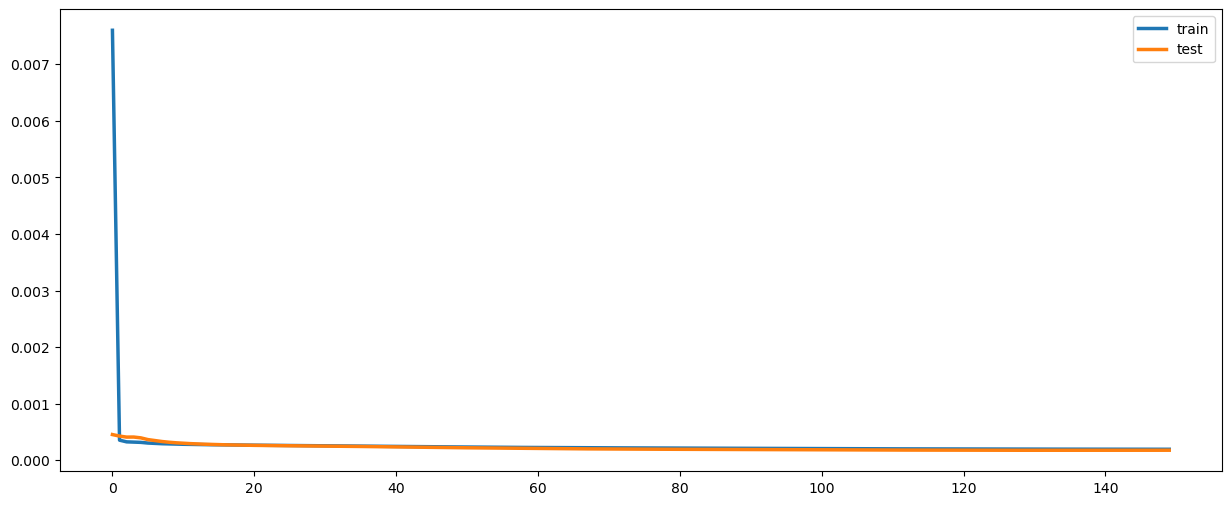

In [83]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [84]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 761us/step


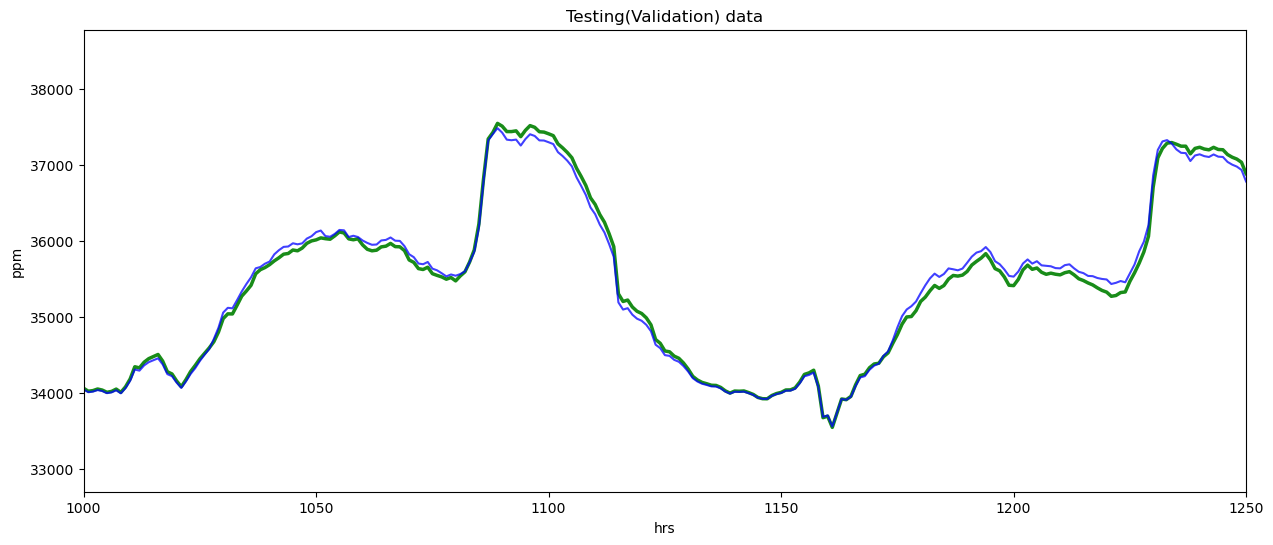

In [85]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [86]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 88.007454
MAPE: 0.2064310247078538 %


# Hai lớp LSTM thêm drop out


In the given code snippet, there are two Dropout layers added to the Sequential model. Let's understand the purpose of each Dropout layer in the context of the overall model architecture:


In the given code snippet, there are two Dropout layers added to the Sequential model. Let's understand the purpose of each Dropout layer in the context of the overall model architecture:

1. First Dropout Layer:

This Dropout layer is added after the first LSTM layer, which has 64 units and returns sequences (return_sequences=True). The purpose of this dropout layer is to introduce regularization and prevent overfitting in the first LSTM layer. With a dropout rate of 0.3, it randomly sets 30% of the input units to 0 during training, helping to improve the model's generalization ability.

2. Second Dropout Layer:

This Dropout layer is added after the second LSTM layer, which has 42 units. Similar to the first Dropout layer, its purpose is to introduce regularization and prevent overfitting in the second LSTM layer. By randomly dropping out 30% of the input units during training, it helps improve the model's generalization and reduce the reliance on specific features or neurons.

These Dropout layers work together with the LSTM layers to mitigate overfitting and improve the model's ability to generalize to unseen data. By randomly dropping out input units during training, they encourage the model to learn more robust representations and prevent it from relying too heavily on specific features or memorizing the training data.

After the Dropout layers, a Dense layer with 1 unit is added, followed by model compilation and training using the fit method.

Note: The provided code snippet only shows the architecture and training process of the model. It's important to ensure that the dataset is appropriately preprocessed before training and that the model's performance is evaluated on a separate test dataset.


In [87]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/500
1119/1119 - 4s - loss: 0.0104 - val_loss: 3.7162e-04 - 4s/epoch - 4ms/step
Epoch 2/500
1119/1119 - 2s - loss: 0.0022 - val_loss: 4.2586e-04 - 2s/epoch - 2ms/step
Epoch 3/500
1119/1119 - 2s - loss: 0.0016 - val_loss: 3.8980e-04 - 2s/epoch - 2ms/step
Epoch 4/500
1119/1119 - 2s - loss: 0.0011 - val_loss: 4.2550e-04 - 2s/epoch - 2ms/step
Epoch 5/500
1119/1119 - 2s - loss: 8.6579e-04 - val_loss: 3.3866e-04 - 2s/epoch - 2ms/step
Epoch 6/500
1119/1119 - 2s - loss: 7.2197e-04 - val_loss: 3.5816e-04 - 2s/epoch - 2ms/step
Epoch 7/500
1119/1119 - 2s - loss: 6.6804e-04 - val_loss: 2.7880e-04 - 2s/epoch - 2ms/step
Epoch 8/500
1119/1119 - 2s - loss: 6.4596e-04 - val_loss: 3.0443e-04 - 2s/epoch - 2ms/step
Epoch 9/500
1119/1119 - 2s - loss: 6.3864e-04 - val_loss: 2.6984e-04 - 2s/epoch - 2ms/step
Epoch 10/500
1119/1119 - 2s - loss: 6.3342e-04 - val_loss: 4.4433e-04 - 2s/epoch - 2ms/step
Epoch 11/500
1119/1119 - 2s - loss: 6.4419e-04 - val_loss: 5.1232e-04 - 2s/epoch - 2ms/step
Epoch 12/500


Epoch 91/500
1119/1119 - 2s - loss: 5.4911e-04 - val_loss: 1.9223e-04 - 2s/epoch - 2ms/step
Epoch 92/500
1119/1119 - 2s - loss: 5.5316e-04 - val_loss: 2.0545e-04 - 2s/epoch - 2ms/step
Epoch 93/500
1119/1119 - 2s - loss: 5.5179e-04 - val_loss: 1.9363e-04 - 2s/epoch - 2ms/step
Epoch 94/500
1119/1119 - 2s - loss: 5.6398e-04 - val_loss: 2.0332e-04 - 2s/epoch - 2ms/step
Epoch 95/500
1119/1119 - 2s - loss: 5.5775e-04 - val_loss: 2.0089e-04 - 2s/epoch - 2ms/step
Epoch 96/500
1119/1119 - 2s - loss: 5.5336e-04 - val_loss: 2.4326e-04 - 2s/epoch - 2ms/step
Epoch 97/500
1119/1119 - 2s - loss: 5.6089e-04 - val_loss: 1.9583e-04 - 2s/epoch - 2ms/step
Epoch 98/500
1119/1119 - 2s - loss: 5.6245e-04 - val_loss: 2.1659e-04 - 2s/epoch - 2ms/step
Epoch 99/500
1119/1119 - 2s - loss: 5.5923e-04 - val_loss: 2.1907e-04 - 2s/epoch - 2ms/step
Epoch 100/500
1119/1119 - 2s - loss: 5.5976e-04 - val_loss: 1.9542e-04 - 2s/epoch - 2ms/step
Epoch 101/500
1119/1119 - 2s - loss: 5.4327e-04 - val_loss: 2.0444e-04 - 2s/epo

Epoch 180/500
1119/1119 - 2s - loss: 5.4888e-04 - val_loss: 1.8427e-04 - 2s/epoch - 2ms/step
Epoch 181/500
1119/1119 - 2s - loss: 5.4416e-04 - val_loss: 1.9062e-04 - 2s/epoch - 2ms/step
Epoch 182/500
1119/1119 - 2s - loss: 5.4459e-04 - val_loss: 2.0172e-04 - 2s/epoch - 2ms/step
Epoch 183/500
1119/1119 - 2s - loss: 5.3530e-04 - val_loss: 1.9135e-04 - 2s/epoch - 2ms/step
Epoch 184/500
1119/1119 - 2s - loss: 5.3946e-04 - val_loss: 2.1786e-04 - 2s/epoch - 2ms/step
Epoch 185/500
1119/1119 - 2s - loss: 5.3880e-04 - val_loss: 1.7730e-04 - 2s/epoch - 2ms/step
Epoch 186/500
1119/1119 - 2s - loss: 5.3729e-04 - val_loss: 1.9356e-04 - 2s/epoch - 2ms/step
Epoch 187/500
1119/1119 - 2s - loss: 5.4974e-04 - val_loss: 1.8781e-04 - 2s/epoch - 2ms/step
Epoch 188/500
1119/1119 - 2s - loss: 5.4891e-04 - val_loss: 1.7636e-04 - 2s/epoch - 2ms/step
Epoch 189/500
1119/1119 - 2s - loss: 5.4727e-04 - val_loss: 1.8499e-04 - 2s/epoch - 2ms/step
Epoch 190/500
1119/1119 - 2s - loss: 5.4364e-04 - val_loss: 1.9530e-04

1119/1119 - 2s - loss: 5.3268e-04 - val_loss: 1.9008e-04 - 2s/epoch - 2ms/step
Epoch 269/500
1119/1119 - 2s - loss: 5.4310e-04 - val_loss: 1.7932e-04 - 2s/epoch - 2ms/step
Epoch 270/500
1119/1119 - 2s - loss: 5.2944e-04 - val_loss: 1.7313e-04 - 2s/epoch - 2ms/step
Epoch 271/500
1119/1119 - 2s - loss: 5.3918e-04 - val_loss: 2.0691e-04 - 2s/epoch - 2ms/step
Epoch 272/500
1119/1119 - 2s - loss: 5.3789e-04 - val_loss: 2.0138e-04 - 2s/epoch - 2ms/step
Epoch 273/500
1119/1119 - 2s - loss: 5.2575e-04 - val_loss: 1.8095e-04 - 2s/epoch - 2ms/step
Epoch 274/500
1119/1119 - 2s - loss: 5.3587e-04 - val_loss: 1.8958e-04 - 2s/epoch - 2ms/step
Epoch 275/500
1119/1119 - 2s - loss: 5.3135e-04 - val_loss: 2.2587e-04 - 2s/epoch - 2ms/step
Epoch 276/500
1119/1119 - 2s - loss: 5.2917e-04 - val_loss: 1.7536e-04 - 2s/epoch - 2ms/step
Epoch 277/500
1119/1119 - 2s - loss: 5.3145e-04 - val_loss: 1.8781e-04 - 2s/epoch - 2ms/step
Epoch 278/500
1119/1119 - 2s - loss: 5.2956e-04 - val_loss: 2.1501e-04 - 2s/epoch - 

Epoch 357/500
1119/1119 - 2s - loss: 5.3501e-04 - val_loss: 1.7496e-04 - 2s/epoch - 2ms/step
Epoch 358/500
1119/1119 - 2s - loss: 5.3145e-04 - val_loss: 2.0858e-04 - 2s/epoch - 2ms/step
Epoch 359/500
1119/1119 - 2s - loss: 5.4000e-04 - val_loss: 1.9124e-04 - 2s/epoch - 2ms/step
Epoch 360/500
1119/1119 - 2s - loss: 5.3024e-04 - val_loss: 1.8559e-04 - 2s/epoch - 2ms/step
Epoch 361/500
1119/1119 - 2s - loss: 5.2676e-04 - val_loss: 1.9355e-04 - 2s/epoch - 2ms/step
Epoch 362/500
1119/1119 - 2s - loss: 5.3460e-04 - val_loss: 2.1936e-04 - 2s/epoch - 2ms/step
Epoch 363/500
1119/1119 - 2s - loss: 5.3638e-04 - val_loss: 2.0913e-04 - 2s/epoch - 2ms/step
Epoch 364/500
1119/1119 - 2s - loss: 5.2523e-04 - val_loss: 2.2765e-04 - 2s/epoch - 2ms/step
Epoch 365/500
1119/1119 - 2s - loss: 5.3523e-04 - val_loss: 1.7350e-04 - 2s/epoch - 2ms/step
Epoch 366/500
1119/1119 - 2s - loss: 5.2280e-04 - val_loss: 2.2238e-04 - 2s/epoch - 2ms/step
Epoch 367/500
1119/1119 - 2s - loss: 5.3097e-04 - val_loss: 1.9871e-04

1119/1119 - 2s - loss: 5.3806e-04 - val_loss: 2.6975e-04 - 2s/epoch - 2ms/step
Epoch 446/500
1119/1119 - 2s - loss: 5.2653e-04 - val_loss: 1.9048e-04 - 2s/epoch - 2ms/step
Epoch 447/500
1119/1119 - 2s - loss: 5.2573e-04 - val_loss: 2.5400e-04 - 2s/epoch - 2ms/step
Epoch 448/500
1119/1119 - 2s - loss: 5.3341e-04 - val_loss: 1.9057e-04 - 2s/epoch - 2ms/step
Epoch 449/500
1119/1119 - 2s - loss: 5.1955e-04 - val_loss: 2.6063e-04 - 2s/epoch - 2ms/step
Epoch 450/500
1119/1119 - 2s - loss: 5.2215e-04 - val_loss: 1.9094e-04 - 2s/epoch - 2ms/step
Epoch 451/500
1119/1119 - 2s - loss: 5.2879e-04 - val_loss: 2.8093e-04 - 2s/epoch - 2ms/step
Epoch 452/500
1119/1119 - 2s - loss: 5.2163e-04 - val_loss: 2.8592e-04 - 2s/epoch - 2ms/step
Epoch 453/500
1119/1119 - 2s - loss: 5.3004e-04 - val_loss: 2.2090e-04 - 2s/epoch - 2ms/step
Epoch 454/500
1119/1119 - 2s - loss: 5.3225e-04 - val_loss: 2.3784e-04 - 2s/epoch - 2ms/step
Epoch 455/500
1119/1119 - 2s - loss: 5.2951e-04 - val_loss: 1.8995e-04 - 2s/epoch - 

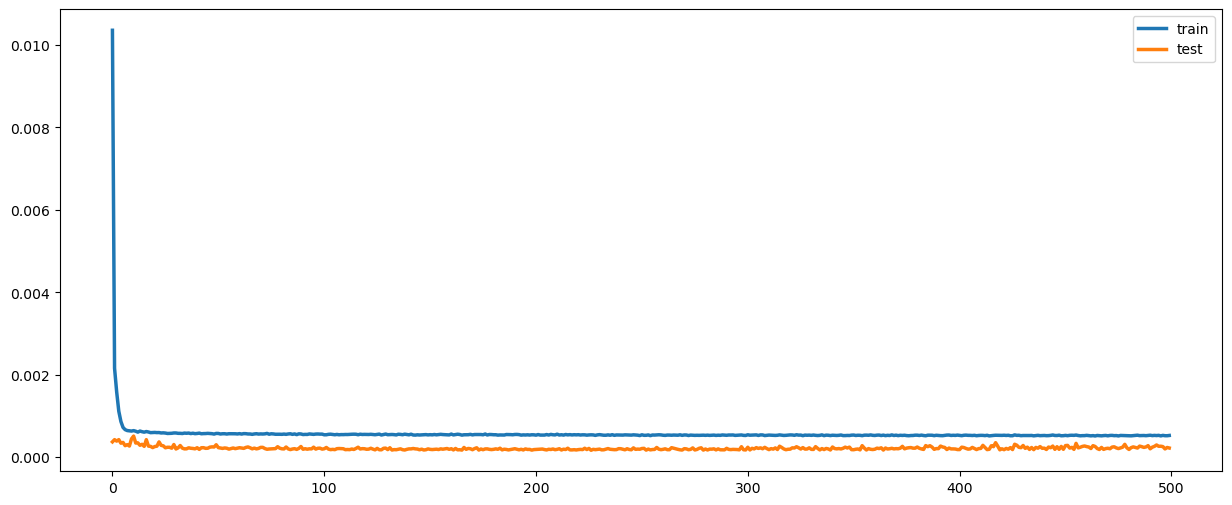

In [88]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [89]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 770us/step


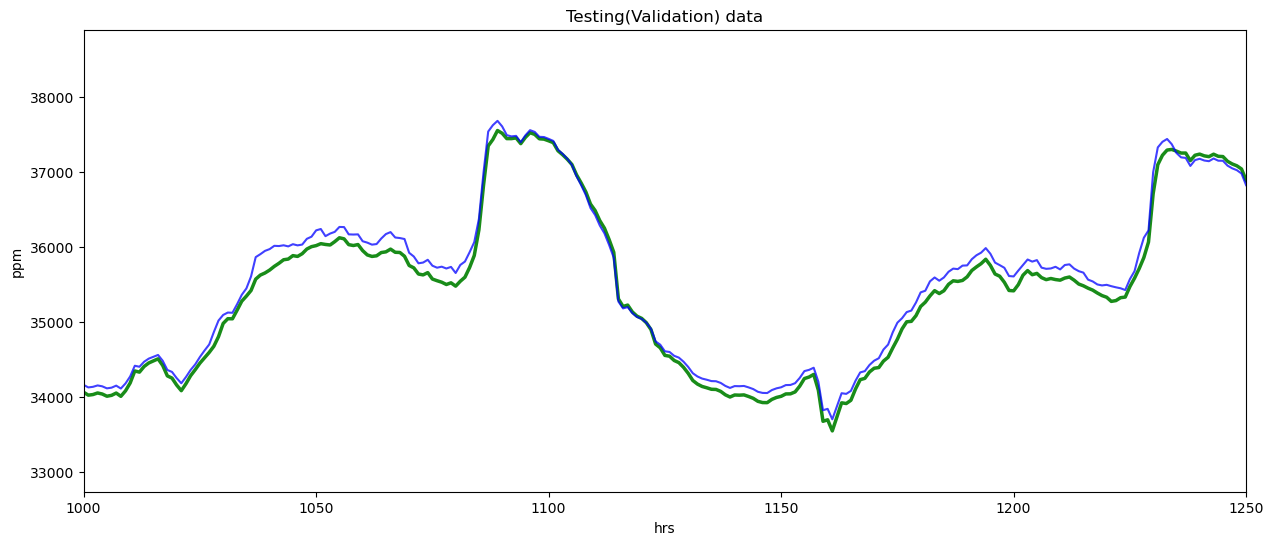

In [90]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [91]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 159.01718
MAPE: 0.3867774037644267 %


## Hai lớp thêm dropout nhưng số lượng epochs = 100

In [92]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 4s - loss: 0.0102 - val_loss: 5.1011e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1119/1119 - 2s - loss: 0.0022 - val_loss: 3.4293e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1119/1119 - 2s - loss: 0.0016 - val_loss: 5.5547e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1119/1119 - 2s - loss: 0.0011 - val_loss: 3.6696e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1119/1119 - 2s - loss: 8.2256e-04 - val_loss: 3.0606e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1119/1119 - 2s - loss: 6.8732e-04 - val_loss: 4.4362e-04 - 2s/epoch - 2ms/step
Epoch 7/100
1119/1119 - 2s - loss: 6.6574e-04 - val_loss: 4.0980e-04 - 2s/epoch - 2ms/step
Epoch 8/100
1119/1119 - 2s - loss: 6.2994e-04 - val_loss: 2.9804e-04 - 2s/epoch - 2ms/step
Epoch 9/100
1119/1119 - 2s - loss: 6.2662e-04 - val_loss: 3.4152e-04 - 2s/epoch - 2ms/step
Epoch 10/100
1119/1119 - 2s - loss: 6.4220e-04 - val_loss: 3.2590e-04 - 2s/epoch - 2ms/step
Epoch 11/100
1119/1119 - 2s - loss: 6.2142e-04 - val_loss: 3.8088e-04 - 2s/epoch - 2ms/step
Epoch 12/100


Epoch 91/100
1119/1119 - 2s - loss: 5.6054e-04 - val_loss: 2.0189e-04 - 2s/epoch - 2ms/step
Epoch 92/100
1119/1119 - 2s - loss: 5.6912e-04 - val_loss: 1.9842e-04 - 2s/epoch - 2ms/step
Epoch 93/100
1119/1119 - 2s - loss: 5.6231e-04 - val_loss: 2.4173e-04 - 2s/epoch - 2ms/step
Epoch 94/100
1119/1119 - 2s - loss: 5.6570e-04 - val_loss: 1.9019e-04 - 2s/epoch - 2ms/step
Epoch 95/100
1119/1119 - 2s - loss: 5.5449e-04 - val_loss: 2.1988e-04 - 2s/epoch - 2ms/step
Epoch 96/100
1119/1119 - 2s - loss: 5.6504e-04 - val_loss: 1.9788e-04 - 2s/epoch - 2ms/step
Epoch 97/100
1119/1119 - 2s - loss: 5.5829e-04 - val_loss: 1.9488e-04 - 2s/epoch - 2ms/step
Epoch 98/100
1119/1119 - 2s - loss: 5.5916e-04 - val_loss: 1.8873e-04 - 2s/epoch - 2ms/step
Epoch 99/100
1119/1119 - 2s - loss: 5.5665e-04 - val_loss: 2.2883e-04 - 2s/epoch - 2ms/step
Epoch 100/100
1119/1119 - 2s - loss: 5.5903e-04 - val_loss: 1.8767e-04 - 2s/epoch - 2ms/step


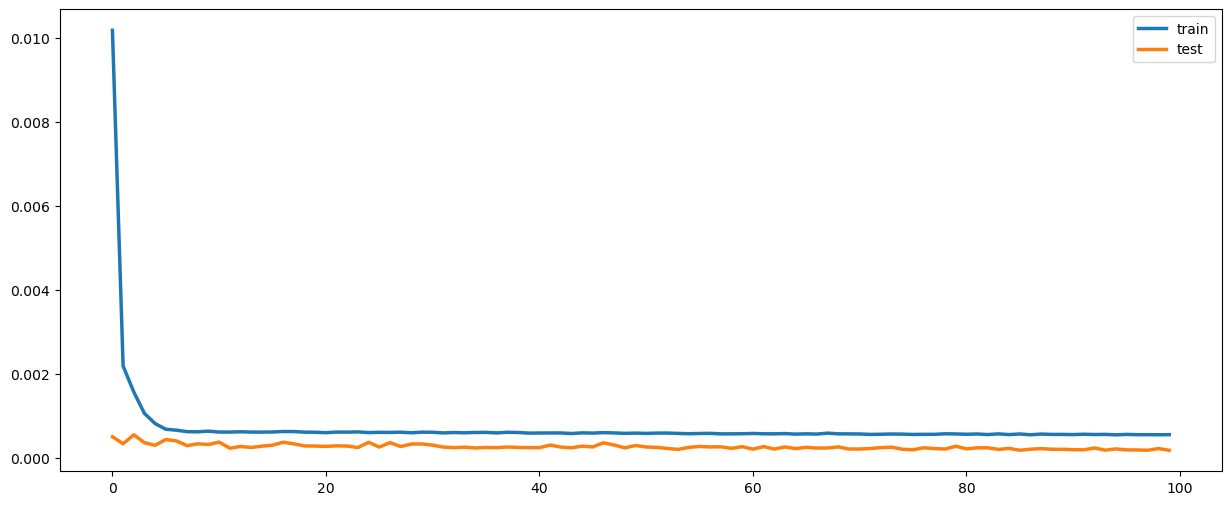

In [93]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [94]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 762us/step


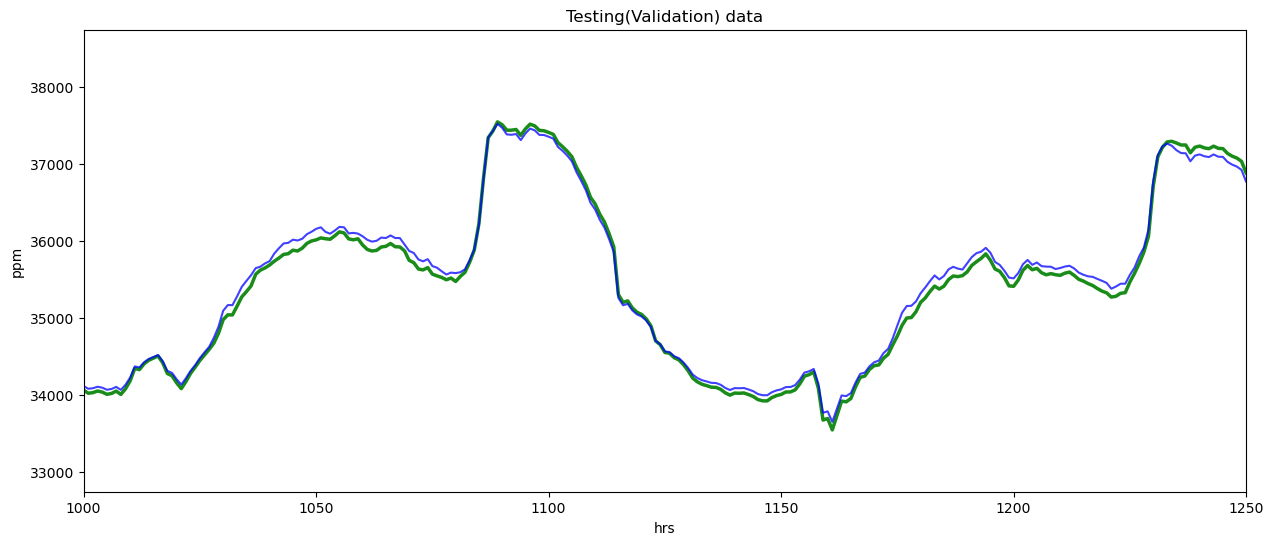

In [95]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [96]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 103.73984
MAPE: 0.2569167176261544 %


## hai lớp thêm dropout nhưng số lượng epochs = 50 

In [97]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 5s - loss: 0.0100 - val_loss: 9.2408e-04 - 5s/epoch - 4ms/step
Epoch 2/100
1119/1119 - 2s - loss: 0.0022 - val_loss: 4.4438e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1119/1119 - 2s - loss: 0.0015 - val_loss: 4.6968e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1119/1119 - 2s - loss: 0.0011 - val_loss: 3.7531e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1119/1119 - 2s - loss: 8.0675e-04 - val_loss: 3.7048e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1119/1119 - 2s - loss: 6.8914e-04 - val_loss: 5.6580e-04 - 2s/epoch - 2ms/step
Epoch 7/100
1119/1119 - 2s - loss: 6.5646e-04 - val_loss: 4.7951e-04 - 2s/epoch - 2ms/step
Epoch 8/100
1119/1119 - 2s - loss: 6.3830e-04 - val_loss: 4.2211e-04 - 2s/epoch - 2ms/step
Epoch 9/100
1119/1119 - 2s - loss: 6.4021e-04 - val_loss: 3.1886e-04 - 2s/epoch - 2ms/step
Epoch 10/100
1119/1119 - 2s - loss: 6.3377e-04 - val_loss: 3.9260e-04 - 2s/epoch - 2ms/step
Epoch 11/100
1119/1119 - 2s - loss: 6.1976e-04 - val_loss: 3.6340e-04 - 2s/epoch - 2ms/step
Epoch 12/100


Epoch 91/100
1119/1119 - 2s - loss: 5.5581e-04 - val_loss: 2.1457e-04 - 2s/epoch - 2ms/step
Epoch 92/100
1119/1119 - 2s - loss: 5.6156e-04 - val_loss: 2.1229e-04 - 2s/epoch - 2ms/step
Epoch 93/100
1119/1119 - 2s - loss: 5.4853e-04 - val_loss: 2.1117e-04 - 2s/epoch - 2ms/step
Epoch 94/100
1119/1119 - 2s - loss: 5.5480e-04 - val_loss: 1.9758e-04 - 2s/epoch - 2ms/step
Epoch 95/100
1119/1119 - 2s - loss: 5.5354e-04 - val_loss: 2.2199e-04 - 2s/epoch - 2ms/step
Epoch 96/100
1119/1119 - 2s - loss: 5.5541e-04 - val_loss: 1.9246e-04 - 2s/epoch - 2ms/step
Epoch 97/100
1119/1119 - 2s - loss: 5.6166e-04 - val_loss: 1.9468e-04 - 2s/epoch - 2ms/step
Epoch 98/100
1119/1119 - 2s - loss: 5.6484e-04 - val_loss: 1.8109e-04 - 2s/epoch - 2ms/step
Epoch 99/100
1119/1119 - 2s - loss: 5.5738e-04 - val_loss: 2.0494e-04 - 2s/epoch - 2ms/step
Epoch 100/100
1119/1119 - 2s - loss: 5.6133e-04 - val_loss: 2.0241e-04 - 2s/epoch - 2ms/step


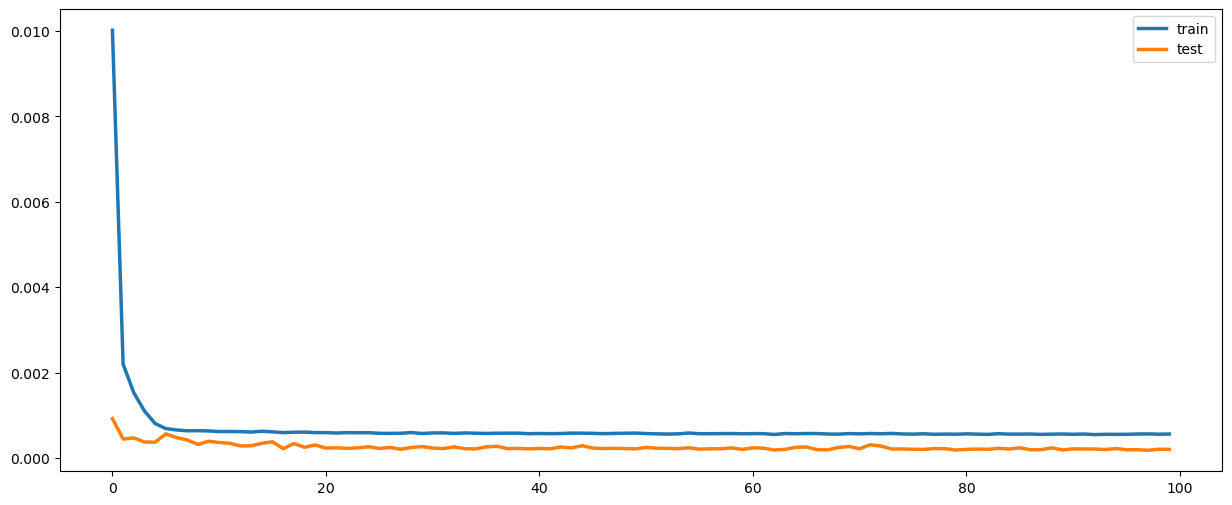

In [98]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [99]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 785us/step


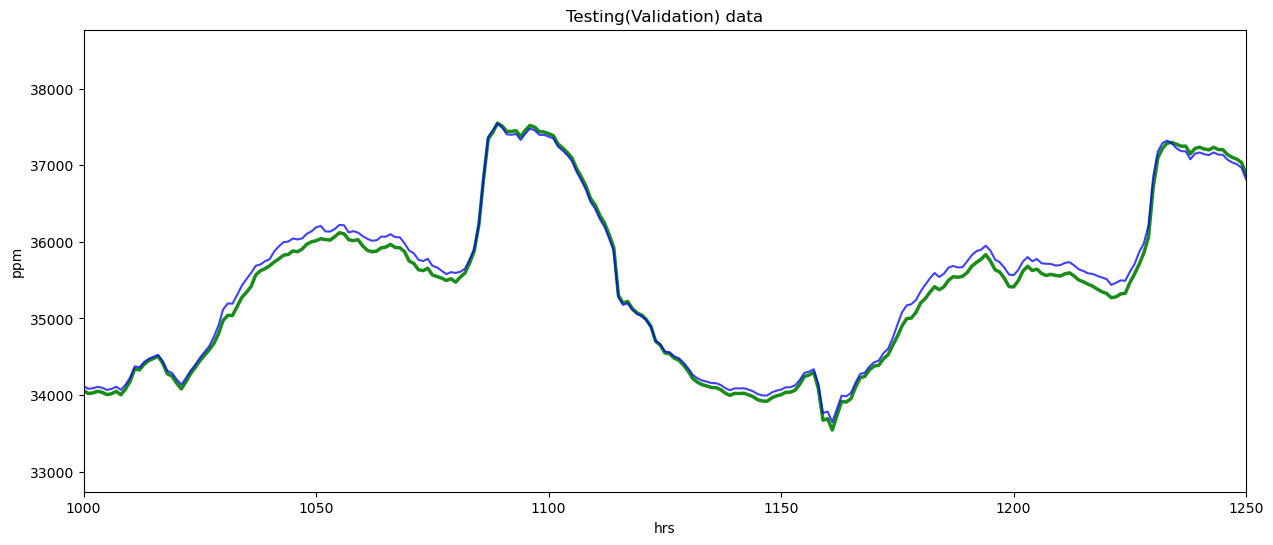

In [100]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [101]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 115.50024
MAPE: 0.27487759944051504 %


## hai lớp thêm dropout nhưng số lượng epochs = 150 

In [102]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(45))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/150
1119/1119 - 4s - loss: 0.0110 - val_loss: 3.9326e-04 - 4s/epoch - 4ms/step
Epoch 2/150
1119/1119 - 2s - loss: 0.0022 - val_loss: 4.7273e-04 - 2s/epoch - 2ms/step
Epoch 3/150
1119/1119 - 2s - loss: 0.0016 - val_loss: 5.8235e-04 - 2s/epoch - 2ms/step
Epoch 4/150
1119/1119 - 2s - loss: 0.0011 - val_loss: 5.8713e-04 - 2s/epoch - 2ms/step
Epoch 5/150
1119/1119 - 2s - loss: 8.0827e-04 - val_loss: 3.7548e-04 - 2s/epoch - 2ms/step
Epoch 6/150
1119/1119 - 2s - loss: 6.9174e-04 - val_loss: 3.7545e-04 - 2s/epoch - 2ms/step
Epoch 7/150
1119/1119 - 2s - loss: 6.5826e-04 - val_loss: 3.2525e-04 - 2s/epoch - 2ms/step
Epoch 8/150
1119/1119 - 2s - loss: 6.4450e-04 - val_loss: 4.1595e-04 - 2s/epoch - 2ms/step
Epoch 9/150
1119/1119 - 2s - loss: 6.3871e-04 - val_loss: 2.6875e-04 - 2s/epoch - 2ms/step
Epoch 10/150
1119/1119 - 2s - loss: 6.3237e-04 - val_loss: 3.2036e-04 - 2s/epoch - 2ms/step
Epoch 11/150
1119/1119 - 2s - loss: 6.3506e-04 - val_loss: 3.2083e-04 - 2s/epoch - 2ms/step
Epoch 12/150


Epoch 91/150
1119/1119 - 2s - loss: 5.5043e-04 - val_loss: 2.2373e-04 - 2s/epoch - 2ms/step
Epoch 92/150
1119/1119 - 2s - loss: 5.5604e-04 - val_loss: 1.8901e-04 - 2s/epoch - 2ms/step
Epoch 93/150
1119/1119 - 2s - loss: 5.5701e-04 - val_loss: 2.2272e-04 - 2s/epoch - 2ms/step
Epoch 94/150
1119/1119 - 2s - loss: 5.5417e-04 - val_loss: 2.0469e-04 - 2s/epoch - 2ms/step
Epoch 95/150
1119/1119 - 2s - loss: 5.4848e-04 - val_loss: 1.9129e-04 - 2s/epoch - 2ms/step
Epoch 96/150
1119/1119 - 2s - loss: 5.6332e-04 - val_loss: 1.9375e-04 - 2s/epoch - 2ms/step
Epoch 97/150
1119/1119 - 2s - loss: 5.4401e-04 - val_loss: 2.6722e-04 - 2s/epoch - 2ms/step
Epoch 98/150
1119/1119 - 2s - loss: 5.6736e-04 - val_loss: 2.0819e-04 - 2s/epoch - 2ms/step
Epoch 99/150
1119/1119 - 2s - loss: 5.5585e-04 - val_loss: 2.0112e-04 - 2s/epoch - 2ms/step
Epoch 100/150
1119/1119 - 2s - loss: 5.5575e-04 - val_loss: 1.9940e-04 - 2s/epoch - 2ms/step
Epoch 101/150
1119/1119 - 2s - loss: 5.4621e-04 - val_loss: 2.0768e-04 - 2s/epo

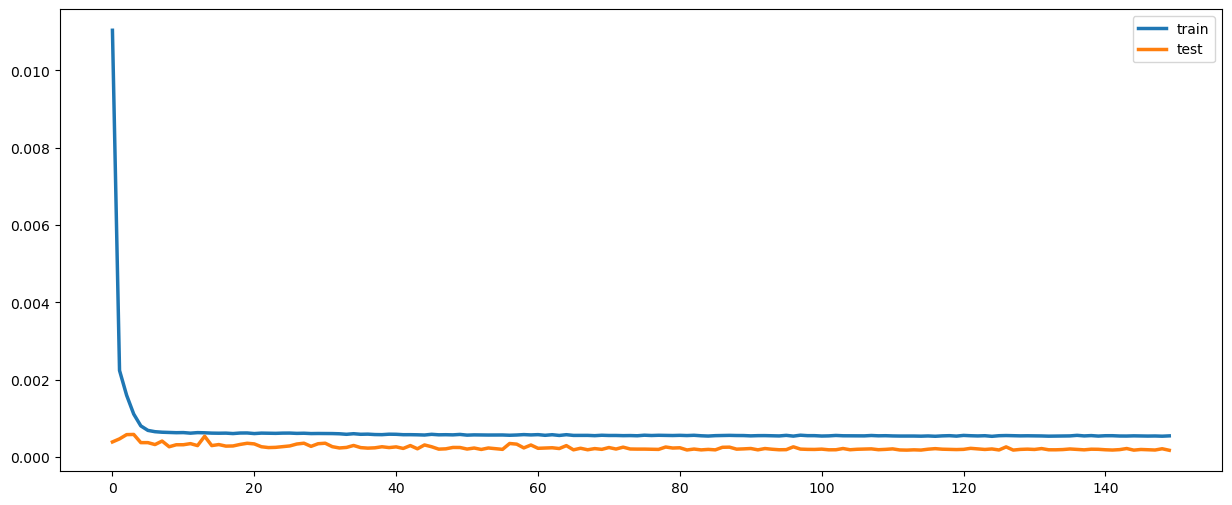

In [103]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [104]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 831us/step


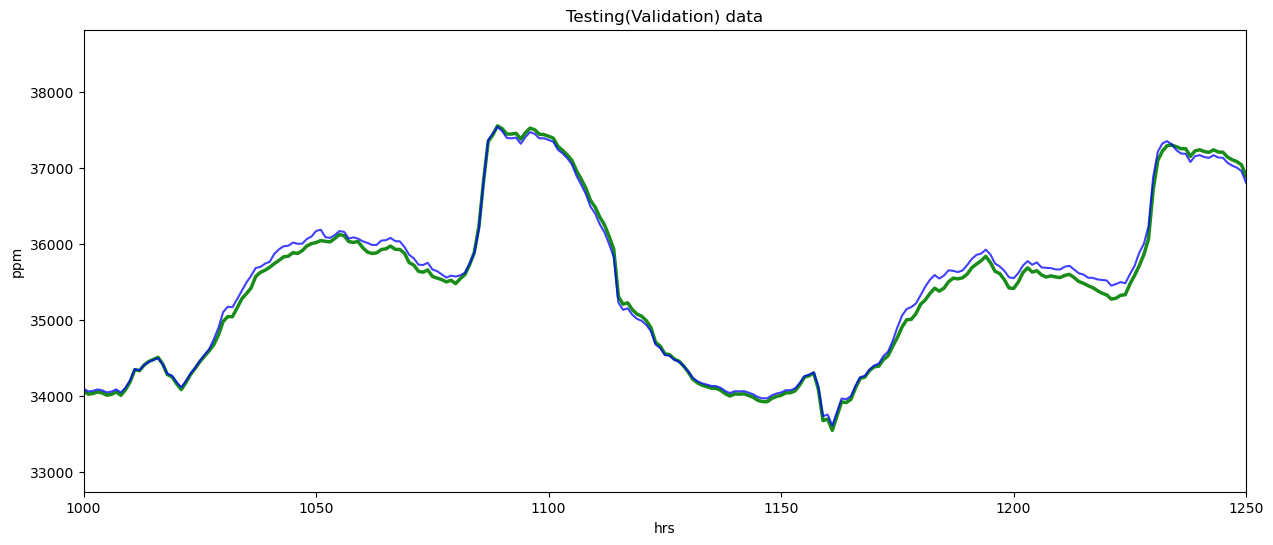

In [105]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [106]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 92.75556
MAPE: 0.22231056354939938 %


## Di chuyển vị trí lớp dropout

In [107]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/500
1119/1119 - 4s - loss: 0.0103 - val_loss: 3.6089e-04 - 4s/epoch - 4ms/step
Epoch 2/500
1119/1119 - 2s - loss: 0.0014 - val_loss: 3.6423e-04 - 2s/epoch - 2ms/step
Epoch 3/500
1119/1119 - 2s - loss: 9.2892e-04 - val_loss: 4.6584e-04 - 2s/epoch - 2ms/step
Epoch 4/500
1119/1119 - 2s - loss: 7.8143e-04 - val_loss: 5.1469e-04 - 2s/epoch - 2ms/step
Epoch 5/500
1119/1119 - 2s - loss: 6.7878e-04 - val_loss: 4.1501e-04 - 2s/epoch - 2ms/step
Epoch 6/500
1119/1119 - 2s - loss: 6.2996e-04 - val_loss: 2.9530e-04 - 2s/epoch - 2ms/step
Epoch 7/500
1119/1119 - 2s - loss: 5.8311e-04 - val_loss: 3.6775e-04 - 2s/epoch - 2ms/step
Epoch 8/500
1119/1119 - 2s - loss: 5.6097e-04 - val_loss: 2.8976e-04 - 2s/epoch - 2ms/step
Epoch 9/500
1119/1119 - 2s - loss: 5.3817e-04 - val_loss: 2.5662e-04 - 2s/epoch - 2ms/step
Epoch 10/500
1119/1119 - 2s - loss: 5.3170e-04 - val_loss: 3.7489e-04 - 2s/epoch - 2ms/step
Epoch 11/500
1119/1119 - 2s - loss: 5.2442e-04 - val_loss: 2.6726e-04 - 2s/epoch - 2ms/step
Epoch

Epoch 91/500
1119/1119 - 2s - loss: 3.5370e-04 - val_loss: 2.3257e-04 - 2s/epoch - 2ms/step
Epoch 92/500
1119/1119 - 2s - loss: 3.5389e-04 - val_loss: 2.4675e-04 - 2s/epoch - 2ms/step
Epoch 93/500
1119/1119 - 2s - loss: 3.5069e-04 - val_loss: 2.0282e-04 - 2s/epoch - 2ms/step
Epoch 94/500
1119/1119 - 2s - loss: 3.4247e-04 - val_loss: 2.0528e-04 - 2s/epoch - 2ms/step
Epoch 95/500
1119/1119 - 2s - loss: 3.4520e-04 - val_loss: 2.0149e-04 - 2s/epoch - 2ms/step
Epoch 96/500
1119/1119 - 2s - loss: 3.4040e-04 - val_loss: 2.2166e-04 - 2s/epoch - 2ms/step
Epoch 97/500
1119/1119 - 2s - loss: 3.4302e-04 - val_loss: 2.1258e-04 - 2s/epoch - 2ms/step
Epoch 98/500
1119/1119 - 2s - loss: 3.4218e-04 - val_loss: 2.0444e-04 - 2s/epoch - 2ms/step
Epoch 99/500
1119/1119 - 2s - loss: 3.4389e-04 - val_loss: 2.4798e-04 - 2s/epoch - 2ms/step
Epoch 100/500
1119/1119 - 2s - loss: 3.4257e-04 - val_loss: 2.2043e-04 - 2s/epoch - 2ms/step
Epoch 101/500
1119/1119 - 2s - loss: 3.3933e-04 - val_loss: 2.2125e-04 - 2s/epo

Epoch 180/500
1119/1119 - 2s - loss: 2.5969e-04 - val_loss: 1.7193e-04 - 2s/epoch - 2ms/step
Epoch 181/500
1119/1119 - 2s - loss: 2.5869e-04 - val_loss: 1.6721e-04 - 2s/epoch - 2ms/step
Epoch 182/500
1119/1119 - 2s - loss: 2.5856e-04 - val_loss: 1.6958e-04 - 2s/epoch - 2ms/step
Epoch 183/500
1119/1119 - 2s - loss: 2.6021e-04 - val_loss: 1.7474e-04 - 2s/epoch - 2ms/step
Epoch 184/500
1119/1119 - 2s - loss: 2.5953e-04 - val_loss: 1.7114e-04 - 2s/epoch - 2ms/step
Epoch 185/500
1119/1119 - 2s - loss: 2.5974e-04 - val_loss: 1.6517e-04 - 2s/epoch - 2ms/step
Epoch 186/500
1119/1119 - 2s - loss: 2.5926e-04 - val_loss: 1.7239e-04 - 2s/epoch - 2ms/step
Epoch 187/500
1119/1119 - 2s - loss: 2.5794e-04 - val_loss: 1.8548e-04 - 2s/epoch - 2ms/step
Epoch 188/500
1119/1119 - 2s - loss: 2.5990e-04 - val_loss: 1.6702e-04 - 2s/epoch - 2ms/step
Epoch 189/500
1119/1119 - 2s - loss: 2.5815e-04 - val_loss: 1.6999e-04 - 2s/epoch - 2ms/step
Epoch 190/500
1119/1119 - 2s - loss: 2.5621e-04 - val_loss: 1.7212e-04

1119/1119 - 2s - loss: 2.4582e-04 - val_loss: 1.7123e-04 - 2s/epoch - 2ms/step
Epoch 269/500
1119/1119 - 2s - loss: 2.4534e-04 - val_loss: 1.6539e-04 - 2s/epoch - 2ms/step
Epoch 270/500
1119/1119 - 2s - loss: 2.4531e-04 - val_loss: 1.7222e-04 - 2s/epoch - 2ms/step
Epoch 271/500
1119/1119 - 2s - loss: 2.4667e-04 - val_loss: 1.6878e-04 - 2s/epoch - 2ms/step
Epoch 272/500
1119/1119 - 2s - loss: 2.4389e-04 - val_loss: 1.6990e-04 - 2s/epoch - 2ms/step
Epoch 273/500
1119/1119 - 2s - loss: 2.4288e-04 - val_loss: 1.6437e-04 - 2s/epoch - 2ms/step
Epoch 274/500
1119/1119 - 2s - loss: 2.4220e-04 - val_loss: 1.7005e-04 - 2s/epoch - 2ms/step
Epoch 275/500
1119/1119 - 2s - loss: 2.4173e-04 - val_loss: 1.6392e-04 - 2s/epoch - 2ms/step
Epoch 276/500
1119/1119 - 2s - loss: 2.4581e-04 - val_loss: 1.6346e-04 - 2s/epoch - 2ms/step
Epoch 277/500
1119/1119 - 2s - loss: 2.4311e-04 - val_loss: 1.6629e-04 - 2s/epoch - 2ms/step
Epoch 278/500
1119/1119 - 2s - loss: 2.4108e-04 - val_loss: 1.6017e-04 - 2s/epoch - 

Epoch 357/500
1119/1119 - 2s - loss: 2.3266e-04 - val_loss: 1.7258e-04 - 2s/epoch - 2ms/step
Epoch 358/500
1119/1119 - 2s - loss: 2.3457e-04 - val_loss: 1.6985e-04 - 2s/epoch - 2ms/step
Epoch 359/500
1119/1119 - 2s - loss: 2.3545e-04 - val_loss: 1.6534e-04 - 2s/epoch - 2ms/step
Epoch 360/500
1119/1119 - 2s - loss: 2.3217e-04 - val_loss: 1.6281e-04 - 2s/epoch - 2ms/step
Epoch 361/500
1119/1119 - 2s - loss: 2.3068e-04 - val_loss: 1.6241e-04 - 2s/epoch - 2ms/step
Epoch 362/500
1119/1119 - 2s - loss: 2.3307e-04 - val_loss: 1.6291e-04 - 2s/epoch - 2ms/step
Epoch 363/500
1119/1119 - 2s - loss: 2.2954e-04 - val_loss: 1.7121e-04 - 2s/epoch - 2ms/step
Epoch 364/500
1119/1119 - 2s - loss: 2.3206e-04 - val_loss: 1.6578e-04 - 2s/epoch - 2ms/step
Epoch 365/500
1119/1119 - 2s - loss: 2.3245e-04 - val_loss: 1.7267e-04 - 2s/epoch - 2ms/step
Epoch 366/500
1119/1119 - 2s - loss: 2.3150e-04 - val_loss: 1.6630e-04 - 2s/epoch - 2ms/step
Epoch 367/500
1119/1119 - 2s - loss: 2.3055e-04 - val_loss: 1.6738e-04

1119/1119 - 2s - loss: 2.2362e-04 - val_loss: 1.6201e-04 - 2s/epoch - 2ms/step
Epoch 446/500
1119/1119 - 2s - loss: 2.2676e-04 - val_loss: 1.6975e-04 - 2s/epoch - 2ms/step
Epoch 447/500
1119/1119 - 2s - loss: 2.2541e-04 - val_loss: 1.6541e-04 - 2s/epoch - 2ms/step
Epoch 448/500
1119/1119 - 2s - loss: 2.2558e-04 - val_loss: 1.6581e-04 - 2s/epoch - 2ms/step
Epoch 449/500
1119/1119 - 2s - loss: 2.2701e-04 - val_loss: 1.6731e-04 - 2s/epoch - 2ms/step
Epoch 450/500
1119/1119 - 2s - loss: 2.2669e-04 - val_loss: 1.6536e-04 - 2s/epoch - 2ms/step
Epoch 451/500
1119/1119 - 2s - loss: 2.2431e-04 - val_loss: 1.6333e-04 - 2s/epoch - 2ms/step
Epoch 452/500
1119/1119 - 2s - loss: 2.2391e-04 - val_loss: 1.6489e-04 - 2s/epoch - 2ms/step
Epoch 453/500
1119/1119 - 2s - loss: 2.2400e-04 - val_loss: 1.6113e-04 - 2s/epoch - 2ms/step
Epoch 454/500
1119/1119 - 2s - loss: 2.2498e-04 - val_loss: 1.7840e-04 - 2s/epoch - 2ms/step
Epoch 455/500
1119/1119 - 2s - loss: 2.2831e-04 - val_loss: 1.6486e-04 - 2s/epoch - 

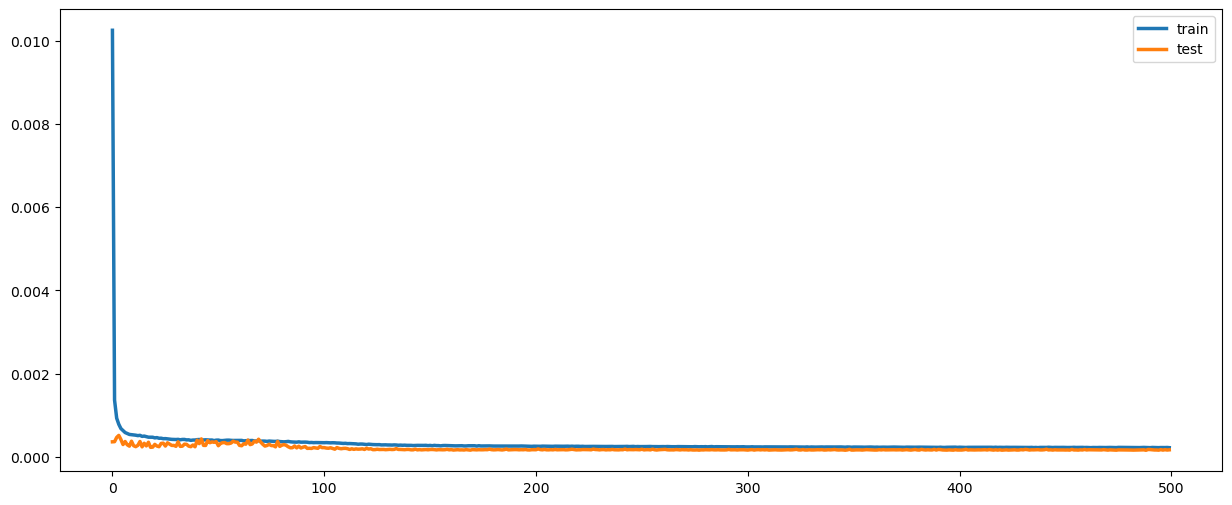

In [108]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [109]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 878us/step


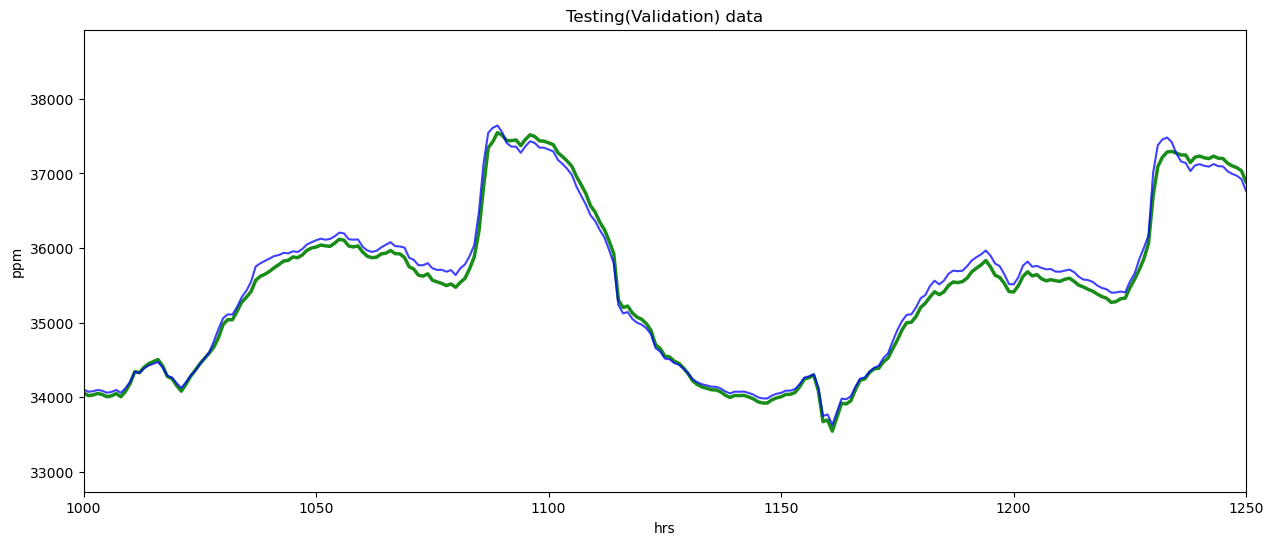

In [110]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [111]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 121.5155
MAPE: 0.28339598793536425 %


## DỊCH CHUYỂN VỊ TRÍ DROPOUT NHƯNG EPOCHS = 100

In [112]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 5s - loss: 0.0103 - val_loss: 4.5620e-04 - 5s/epoch - 4ms/step
Epoch 2/100
1119/1119 - 2s - loss: 0.0014 - val_loss: 6.0795e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1119/1119 - 2s - loss: 9.4468e-04 - val_loss: 4.6693e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1119/1119 - 2s - loss: 7.9622e-04 - val_loss: 4.2848e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1119/1119 - 2s - loss: 6.9208e-04 - val_loss: 3.7448e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1119/1119 - 2s - loss: 6.2566e-04 - val_loss: 3.0108e-04 - 2s/epoch - 2ms/step
Epoch 7/100
1119/1119 - 2s - loss: 6.0758e-04 - val_loss: 3.2472e-04 - 2s/epoch - 2ms/step
Epoch 8/100
1119/1119 - 2s - loss: 5.7826e-04 - val_loss: 2.8757e-04 - 2s/epoch - 2ms/step
Epoch 9/100
1119/1119 - 2s - loss: 5.4862e-04 - val_loss: 2.5690e-04 - 2s/epoch - 2ms/step
Epoch 10/100
1119/1119 - 2s - loss: 5.2939e-04 - val_loss: 2.6267e-04 - 2s/epoch - 2ms/step
Epoch 11/100
1119/1119 - 2s - loss: 5.3062e-04 - val_loss: 2.4338e-04 - 2s/epoch - 2ms/step
Epoch

Epoch 91/100
1119/1119 - 2s - loss: 3.4523e-04 - val_loss: 1.9954e-04 - 2s/epoch - 2ms/step
Epoch 92/100
1119/1119 - 2s - loss: 3.5317e-04 - val_loss: 2.3278e-04 - 2s/epoch - 2ms/step
Epoch 93/100
1119/1119 - 2s - loss: 3.4222e-04 - val_loss: 2.1736e-04 - 2s/epoch - 2ms/step
Epoch 94/100
1119/1119 - 2s - loss: 3.5075e-04 - val_loss: 2.9927e-04 - 2s/epoch - 2ms/step
Epoch 95/100
1119/1119 - 2s - loss: 3.5248e-04 - val_loss: 2.0691e-04 - 2s/epoch - 2ms/step
Epoch 96/100
1119/1119 - 2s - loss: 3.4558e-04 - val_loss: 1.9752e-04 - 2s/epoch - 2ms/step
Epoch 97/100
1119/1119 - 2s - loss: 3.4062e-04 - val_loss: 2.0798e-04 - 2s/epoch - 2ms/step
Epoch 98/100
1119/1119 - 2s - loss: 3.3985e-04 - val_loss: 2.2551e-04 - 2s/epoch - 2ms/step
Epoch 99/100
1119/1119 - 2s - loss: 3.4063e-04 - val_loss: 2.0052e-04 - 2s/epoch - 2ms/step
Epoch 100/100
1119/1119 - 2s - loss: 3.3727e-04 - val_loss: 1.9811e-04 - 2s/epoch - 2ms/step


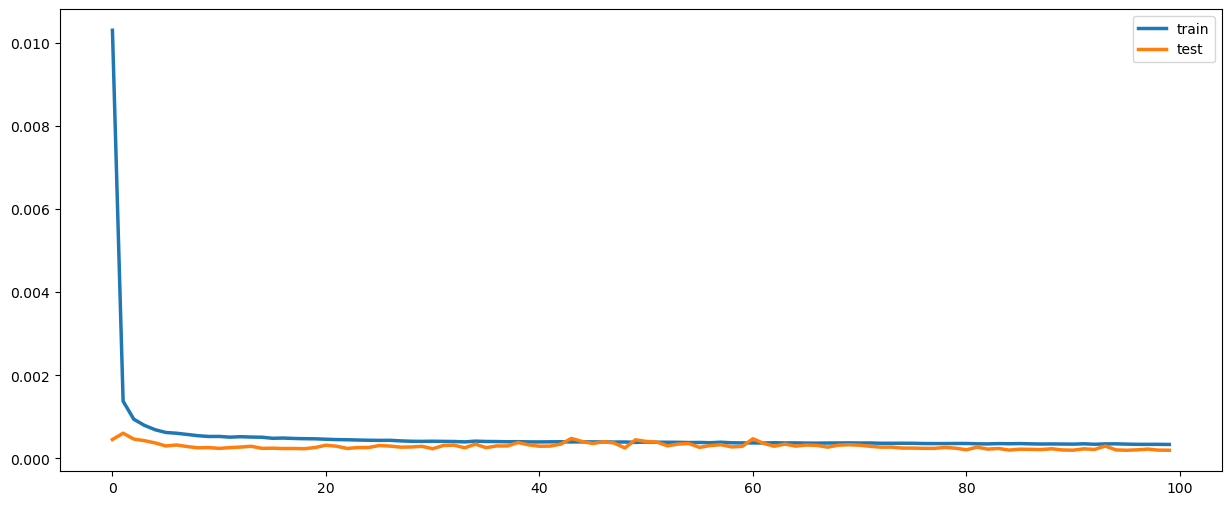

In [113]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [114]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 872us/step


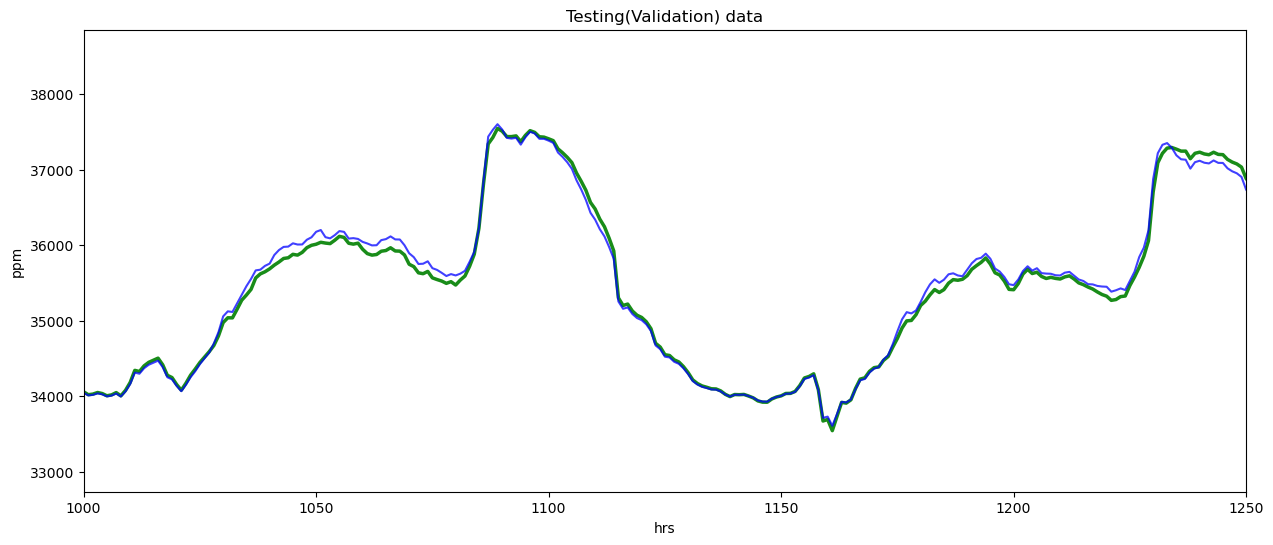

In [115]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [116]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 99.96383
MAPE: 0.2125713974237442 %


## DỊCH CHUYỂN VỊ TRÍ DROPOUT NHƯNG EPOCHS = 50

In [117]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 4s - loss: 0.0095 - val_loss: 3.9203e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1119/1119 - 2s - loss: 0.0014 - val_loss: 3.9883e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1119/1119 - 2s - loss: 9.2510e-04 - val_loss: 4.9894e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1119/1119 - 2s - loss: 7.3595e-04 - val_loss: 3.9725e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1119/1119 - 2s - loss: 6.6944e-04 - val_loss: 3.6850e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1119/1119 - 2s - loss: 6.2377e-04 - val_loss: 3.1051e-04 - 2s/epoch - 2ms/step
Epoch 7/100
1119/1119 - 2s - loss: 5.9006e-04 - val_loss: 2.8982e-04 - 2s/epoch - 2ms/step
Epoch 8/100
1119/1119 - 2s - loss: 5.6825e-04 - val_loss: 2.8065e-04 - 2s/epoch - 2ms/step
Epoch 9/100
1119/1119 - 2s - loss: 5.3878e-04 - val_loss: 3.2734e-04 - 2s/epoch - 2ms/step
Epoch 10/100
1119/1119 - 2s - loss: 5.2435e-04 - val_loss: 3.5761e-04 - 2s/epoch - 2ms/step
Epoch 11/100
1119/1119 - 2s - loss: 5.4065e-04 - val_loss: 3.0545e-04 - 2s/epoch - 2ms/step
Epoch

Epoch 91/100
1119/1119 - 2s - loss: 3.5117e-04 - val_loss: 2.1417e-04 - 2s/epoch - 2ms/step
Epoch 92/100
1119/1119 - 2s - loss: 3.5630e-04 - val_loss: 2.0517e-04 - 2s/epoch - 2ms/step
Epoch 93/100
1119/1119 - 2s - loss: 3.4668e-04 - val_loss: 2.0874e-04 - 2s/epoch - 2ms/step
Epoch 94/100
1119/1119 - 2s - loss: 3.5144e-04 - val_loss: 2.1492e-04 - 2s/epoch - 2ms/step
Epoch 95/100
1119/1119 - 2s - loss: 3.4768e-04 - val_loss: 2.1575e-04 - 2s/epoch - 2ms/step
Epoch 96/100
1119/1119 - 2s - loss: 3.4588e-04 - val_loss: 2.5073e-04 - 2s/epoch - 2ms/step
Epoch 97/100
1119/1119 - 2s - loss: 3.4129e-04 - val_loss: 2.1843e-04 - 2s/epoch - 2ms/step
Epoch 98/100
1119/1119 - 2s - loss: 3.3858e-04 - val_loss: 2.1175e-04 - 2s/epoch - 2ms/step
Epoch 99/100
1119/1119 - 2s - loss: 3.4006e-04 - val_loss: 2.7388e-04 - 2s/epoch - 2ms/step
Epoch 100/100
1119/1119 - 2s - loss: 3.4867e-04 - val_loss: 1.9356e-04 - 2s/epoch - 2ms/step


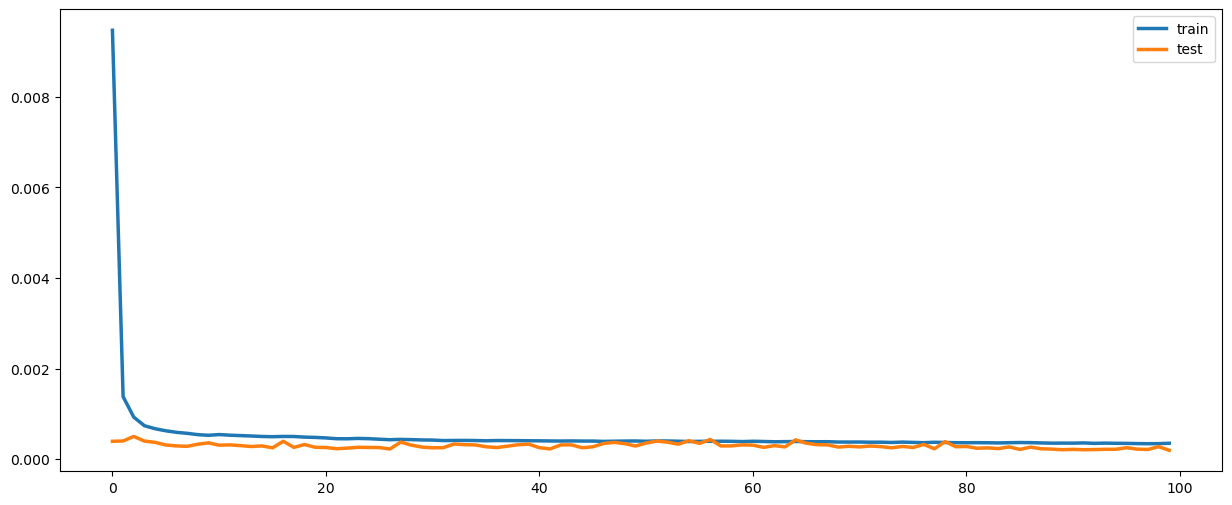

In [118]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [119]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 815us/step


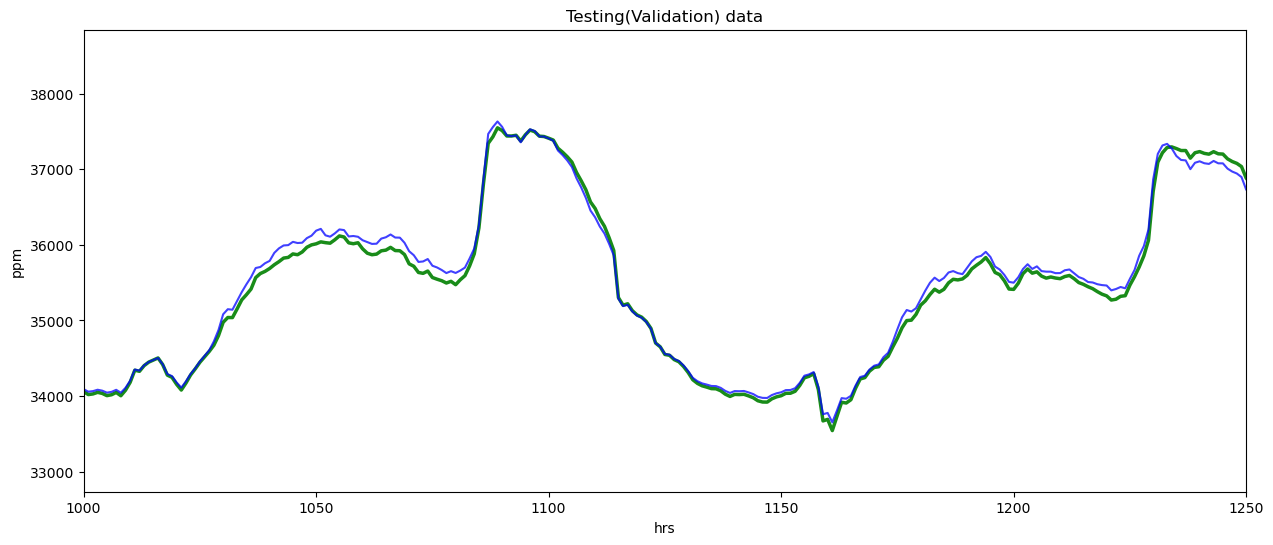

In [120]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [121]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 114.87691
MAPE: 0.26005508843809366 %


## DỊCH CHUYỂN VỊ TRÍ DROPOUT NHƯNG EPOCHS = 150

In [122]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/150
1119/1119 - 5s - loss: 0.0098 - val_loss: 4.8699e-04 - 5s/epoch - 4ms/step
Epoch 2/150
1119/1119 - 2s - loss: 0.0014 - val_loss: 3.9637e-04 - 2s/epoch - 2ms/step
Epoch 3/150
1119/1119 - 2s - loss: 9.1274e-04 - val_loss: 3.8943e-04 - 2s/epoch - 2ms/step
Epoch 4/150
1119/1119 - 2s - loss: 7.6834e-04 - val_loss: 5.3496e-04 - 2s/epoch - 2ms/step
Epoch 5/150
1119/1119 - 2s - loss: 6.8187e-04 - val_loss: 3.5076e-04 - 2s/epoch - 2ms/step
Epoch 6/150
1119/1119 - 2s - loss: 6.2298e-04 - val_loss: 3.5764e-04 - 2s/epoch - 2ms/step
Epoch 7/150
1119/1119 - 2s - loss: 5.8384e-04 - val_loss: 3.1427e-04 - 2s/epoch - 2ms/step
Epoch 8/150
1119/1119 - 2s - loss: 5.6205e-04 - val_loss: 4.1251e-04 - 2s/epoch - 2ms/step
Epoch 9/150
1119/1119 - 2s - loss: 5.4825e-04 - val_loss: 3.0667e-04 - 2s/epoch - 2ms/step
Epoch 10/150
1119/1119 - 2s - loss: 5.1391e-04 - val_loss: 2.4947e-04 - 2s/epoch - 2ms/step
Epoch 11/150
1119/1119 - 2s - loss: 5.2353e-04 - val_loss: 2.8123e-04 - 2s/epoch - 2ms/step
Epoch

Epoch 91/150
1119/1119 - 2s - loss: 3.4892e-04 - val_loss: 2.2789e-04 - 2s/epoch - 2ms/step
Epoch 92/150
1119/1119 - 2s - loss: 3.5066e-04 - val_loss: 2.4908e-04 - 2s/epoch - 2ms/step
Epoch 93/150
1119/1119 - 2s - loss: 3.5158e-04 - val_loss: 2.1404e-04 - 2s/epoch - 2ms/step
Epoch 94/150
1119/1119 - 2s - loss: 3.5112e-04 - val_loss: 2.6024e-04 - 2s/epoch - 2ms/step
Epoch 95/150
1119/1119 - 2s - loss: 3.4990e-04 - val_loss: 2.0657e-04 - 2s/epoch - 2ms/step
Epoch 96/150
1119/1119 - 2s - loss: 3.4238e-04 - val_loss: 2.5678e-04 - 2s/epoch - 2ms/step
Epoch 97/150
1119/1119 - 2s - loss: 3.4855e-04 - val_loss: 2.3945e-04 - 2s/epoch - 2ms/step
Epoch 98/150
1119/1119 - 2s - loss: 3.4461e-04 - val_loss: 2.1073e-04 - 2s/epoch - 2ms/step
Epoch 99/150
1119/1119 - 2s - loss: 3.4266e-04 - val_loss: 2.3614e-04 - 2s/epoch - 2ms/step
Epoch 100/150
1119/1119 - 2s - loss: 3.4298e-04 - val_loss: 2.2135e-04 - 2s/epoch - 2ms/step
Epoch 101/150
1119/1119 - 2s - loss: 3.4721e-04 - val_loss: 2.1158e-04 - 2s/epo

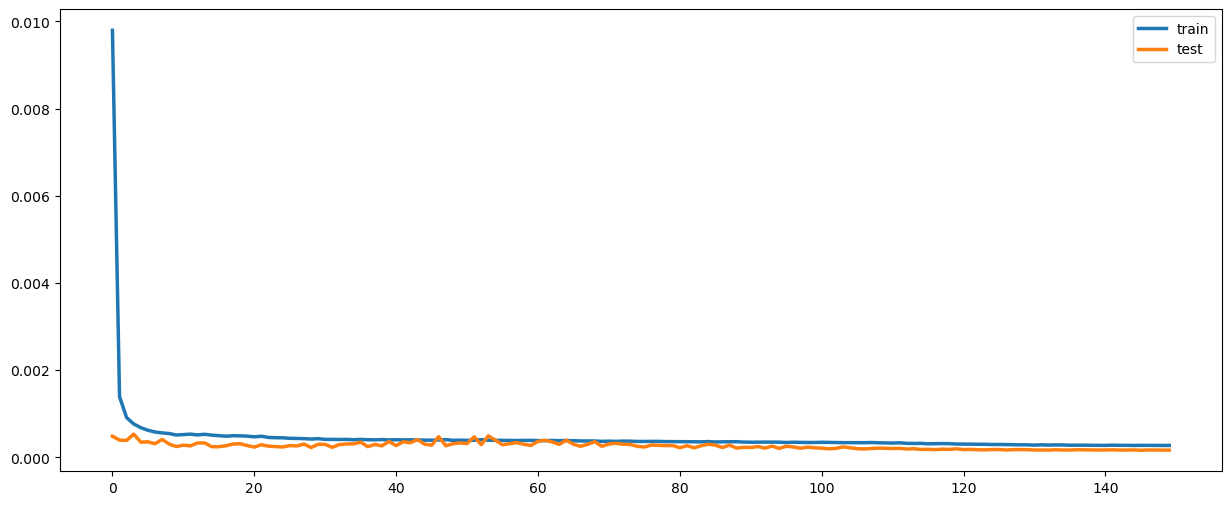

In [123]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [124]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 820us/step


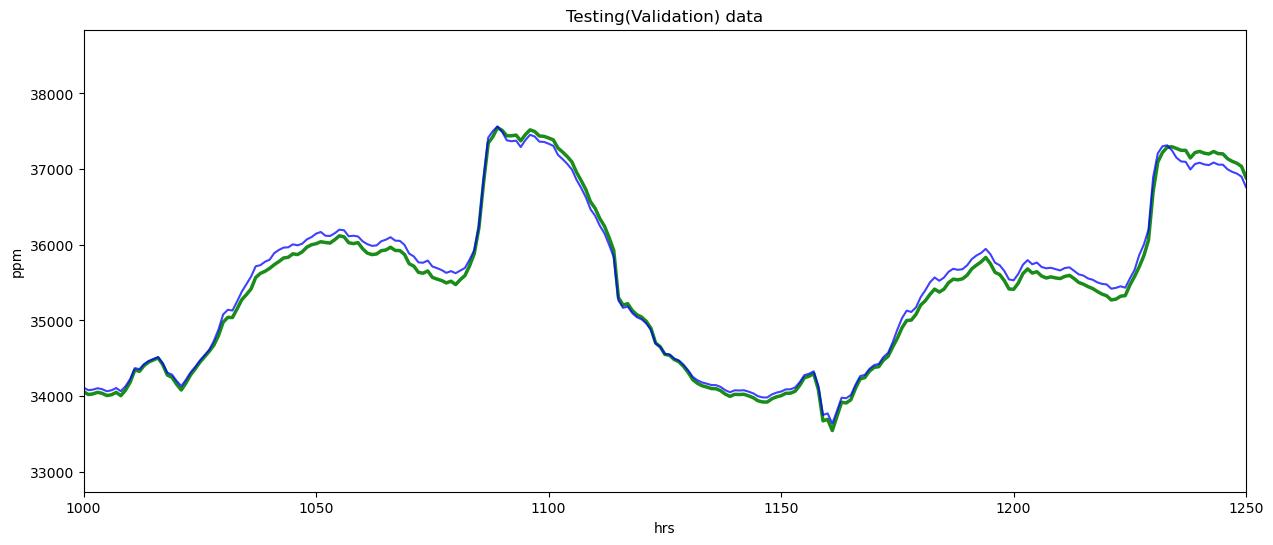

In [125]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [126]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 101.65168
MAPE: 0.23596168030053377 %


## Thêm một lớp dropout

In [127]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(45))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/500
1119/1119 - 4s - loss: 0.0120 - val_loss: 5.1973e-04 - 4s/epoch - 4ms/step
Epoch 2/500
1119/1119 - 2s - loss: 0.0031 - val_loss: 4.7469e-04 - 2s/epoch - 2ms/step
Epoch 3/500
1119/1119 - 2s - loss: 0.0020 - val_loss: 5.8307e-04 - 2s/epoch - 2ms/step
Epoch 4/500
1119/1119 - 2s - loss: 0.0015 - val_loss: 4.5634e-04 - 2s/epoch - 2ms/step
Epoch 5/500
1119/1119 - 2s - loss: 0.0011 - val_loss: 4.0578e-04 - 2s/epoch - 2ms/step
Epoch 6/500
1119/1119 - 2s - loss: 0.0010 - val_loss: 3.7498e-04 - 2s/epoch - 2ms/step
Epoch 7/500
1119/1119 - 2s - loss: 9.6860e-04 - val_loss: 3.5998e-04 - 2s/epoch - 2ms/step
Epoch 8/500
1119/1119 - 2s - loss: 9.1926e-04 - val_loss: 3.8053e-04 - 2s/epoch - 2ms/step
Epoch 9/500
1119/1119 - 2s - loss: 8.9542e-04 - val_loss: 3.1084e-04 - 2s/epoch - 2ms/step
Epoch 10/500
1119/1119 - 2s - loss: 8.8907e-04 - val_loss: 3.4850e-04 - 2s/epoch - 2ms/step
Epoch 11/500
1119/1119 - 2s - loss: 8.8603e-04 - val_loss: 2.7839e-04 - 2s/epoch - 2ms/step
Epoch 12/500
1119/111

Epoch 91/500
1119/1119 - 2s - loss: 7.2264e-04 - val_loss: 2.0030e-04 - 2s/epoch - 2ms/step
Epoch 92/500
1119/1119 - 2s - loss: 7.1607e-04 - val_loss: 1.9378e-04 - 2s/epoch - 2ms/step
Epoch 93/500
1119/1119 - 2s - loss: 7.1642e-04 - val_loss: 2.1043e-04 - 2s/epoch - 2ms/step
Epoch 94/500
1119/1119 - 2s - loss: 7.2292e-04 - val_loss: 1.9515e-04 - 2s/epoch - 2ms/step
Epoch 95/500
1119/1119 - 2s - loss: 7.2537e-04 - val_loss: 2.3205e-04 - 2s/epoch - 2ms/step
Epoch 96/500
1119/1119 - 2s - loss: 7.1374e-04 - val_loss: 2.5675e-04 - 2s/epoch - 2ms/step
Epoch 97/500
1119/1119 - 2s - loss: 7.3042e-04 - val_loss: 2.2777e-04 - 2s/epoch - 2ms/step
Epoch 98/500
1119/1119 - 2s - loss: 7.2717e-04 - val_loss: 2.2699e-04 - 2s/epoch - 2ms/step
Epoch 99/500
1119/1119 - 2s - loss: 7.1673e-04 - val_loss: 2.9830e-04 - 2s/epoch - 2ms/step
Epoch 100/500
1119/1119 - 2s - loss: 7.1307e-04 - val_loss: 2.3674e-04 - 2s/epoch - 2ms/step
Epoch 101/500
1119/1119 - 2s - loss: 7.0648e-04 - val_loss: 3.0278e-04 - 2s/epo

Epoch 180/500
1119/1119 - 2s - loss: 7.0653e-04 - val_loss: 3.2958e-04 - 2s/epoch - 2ms/step
Epoch 181/500
1119/1119 - 2s - loss: 7.0739e-04 - val_loss: 3.2660e-04 - 2s/epoch - 2ms/step
Epoch 182/500
1119/1119 - 2s - loss: 6.9109e-04 - val_loss: 2.6800e-04 - 2s/epoch - 2ms/step
Epoch 183/500
1119/1119 - 2s - loss: 6.9463e-04 - val_loss: 2.0970e-04 - 2s/epoch - 2ms/step
Epoch 184/500
1119/1119 - 2s - loss: 6.9078e-04 - val_loss: 2.6775e-04 - 2s/epoch - 2ms/step
Epoch 185/500
1119/1119 - 2s - loss: 6.9907e-04 - val_loss: 2.6869e-04 - 2s/epoch - 2ms/step
Epoch 186/500
1119/1119 - 2s - loss: 6.9526e-04 - val_loss: 2.4878e-04 - 2s/epoch - 2ms/step
Epoch 187/500
1119/1119 - 2s - loss: 7.0116e-04 - val_loss: 2.8430e-04 - 2s/epoch - 2ms/step
Epoch 188/500
1119/1119 - 2s - loss: 6.8576e-04 - val_loss: 2.7969e-04 - 2s/epoch - 2ms/step
Epoch 189/500
1119/1119 - 2s - loss: 6.9872e-04 - val_loss: 3.1563e-04 - 2s/epoch - 2ms/step
Epoch 190/500
1119/1119 - 2s - loss: 7.0204e-04 - val_loss: 2.5822e-04

1119/1119 - 2s - loss: 6.7777e-04 - val_loss: 2.4695e-04 - 2s/epoch - 2ms/step
Epoch 269/500
1119/1119 - 2s - loss: 6.7866e-04 - val_loss: 2.0538e-04 - 2s/epoch - 2ms/step
Epoch 270/500
1119/1119 - 2s - loss: 6.7520e-04 - val_loss: 4.2796e-04 - 2s/epoch - 2ms/step
Epoch 271/500
1119/1119 - 2s - loss: 6.8345e-04 - val_loss: 2.9452e-04 - 2s/epoch - 2ms/step
Epoch 272/500
1119/1119 - 2s - loss: 6.9127e-04 - val_loss: 2.5843e-04 - 2s/epoch - 2ms/step
Epoch 273/500
1119/1119 - 2s - loss: 6.7362e-04 - val_loss: 2.6604e-04 - 2s/epoch - 2ms/step
Epoch 274/500
1119/1119 - 2s - loss: 6.8002e-04 - val_loss: 2.7203e-04 - 2s/epoch - 2ms/step
Epoch 275/500
1119/1119 - 2s - loss: 6.7327e-04 - val_loss: 2.4710e-04 - 2s/epoch - 2ms/step
Epoch 276/500
1119/1119 - 2s - loss: 6.7637e-04 - val_loss: 2.2095e-04 - 2s/epoch - 2ms/step
Epoch 277/500
1119/1119 - 2s - loss: 6.7342e-04 - val_loss: 2.7990e-04 - 2s/epoch - 2ms/step
Epoch 278/500
1119/1119 - 2s - loss: 6.7017e-04 - val_loss: 2.1964e-04 - 2s/epoch - 

Epoch 357/500
1119/1119 - 2s - loss: 6.5215e-04 - val_loss: 1.8900e-04 - 2s/epoch - 2ms/step
Epoch 358/500
1119/1119 - 2s - loss: 6.6737e-04 - val_loss: 1.8602e-04 - 2s/epoch - 2ms/step
Epoch 359/500
1119/1119 - 2s - loss: 6.5493e-04 - val_loss: 2.4584e-04 - 2s/epoch - 2ms/step
Epoch 360/500
1119/1119 - 2s - loss: 6.6068e-04 - val_loss: 2.3294e-04 - 2s/epoch - 2ms/step
Epoch 361/500
1119/1119 - 2s - loss: 6.6260e-04 - val_loss: 2.2157e-04 - 2s/epoch - 2ms/step
Epoch 362/500
1119/1119 - 2s - loss: 6.5677e-04 - val_loss: 2.1640e-04 - 2s/epoch - 2ms/step
Epoch 363/500
1119/1119 - 2s - loss: 6.5913e-04 - val_loss: 2.8510e-04 - 2s/epoch - 2ms/step
Epoch 364/500
1119/1119 - 2s - loss: 6.5153e-04 - val_loss: 2.1903e-04 - 2s/epoch - 2ms/step
Epoch 365/500
1119/1119 - 2s - loss: 6.5910e-04 - val_loss: 2.1542e-04 - 2s/epoch - 2ms/step
Epoch 366/500
1119/1119 - 2s - loss: 6.5052e-04 - val_loss: 1.9249e-04 - 2s/epoch - 2ms/step
Epoch 367/500
1119/1119 - 2s - loss: 6.5099e-04 - val_loss: 1.9351e-04

1119/1119 - 2s - loss: 6.2807e-04 - val_loss: 2.1340e-04 - 2s/epoch - 2ms/step
Epoch 446/500
1119/1119 - 2s - loss: 6.3783e-04 - val_loss: 1.8867e-04 - 2s/epoch - 2ms/step
Epoch 447/500
1119/1119 - 2s - loss: 6.3802e-04 - val_loss: 2.3861e-04 - 2s/epoch - 2ms/step
Epoch 448/500
1119/1119 - 2s - loss: 6.3217e-04 - val_loss: 2.4173e-04 - 2s/epoch - 2ms/step
Epoch 449/500
1119/1119 - 2s - loss: 6.4074e-04 - val_loss: 2.2874e-04 - 2s/epoch - 2ms/step
Epoch 450/500
1119/1119 - 2s - loss: 6.3279e-04 - val_loss: 2.1260e-04 - 2s/epoch - 2ms/step
Epoch 451/500
1119/1119 - 2s - loss: 6.3253e-04 - val_loss: 2.0183e-04 - 2s/epoch - 2ms/step
Epoch 452/500
1119/1119 - 2s - loss: 6.3279e-04 - val_loss: 2.4431e-04 - 2s/epoch - 2ms/step
Epoch 453/500
1119/1119 - 2s - loss: 6.3699e-04 - val_loss: 2.4569e-04 - 2s/epoch - 2ms/step
Epoch 454/500
1119/1119 - 2s - loss: 6.3590e-04 - val_loss: 2.1290e-04 - 2s/epoch - 2ms/step
Epoch 455/500
1119/1119 - 2s - loss: 6.3869e-04 - val_loss: 1.9452e-04 - 2s/epoch - 

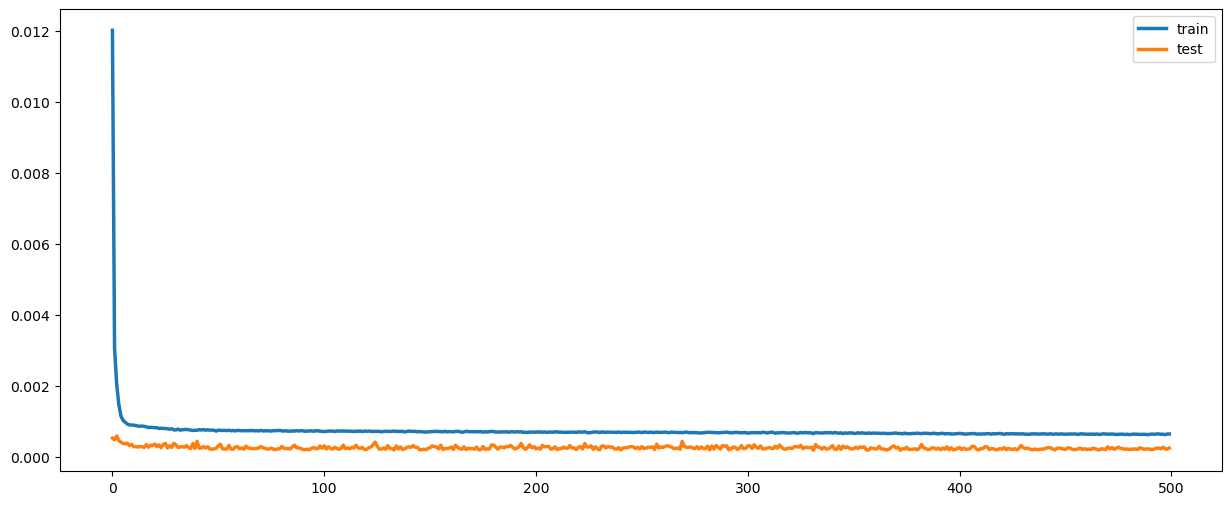

In [128]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [129]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 1s 834us/step


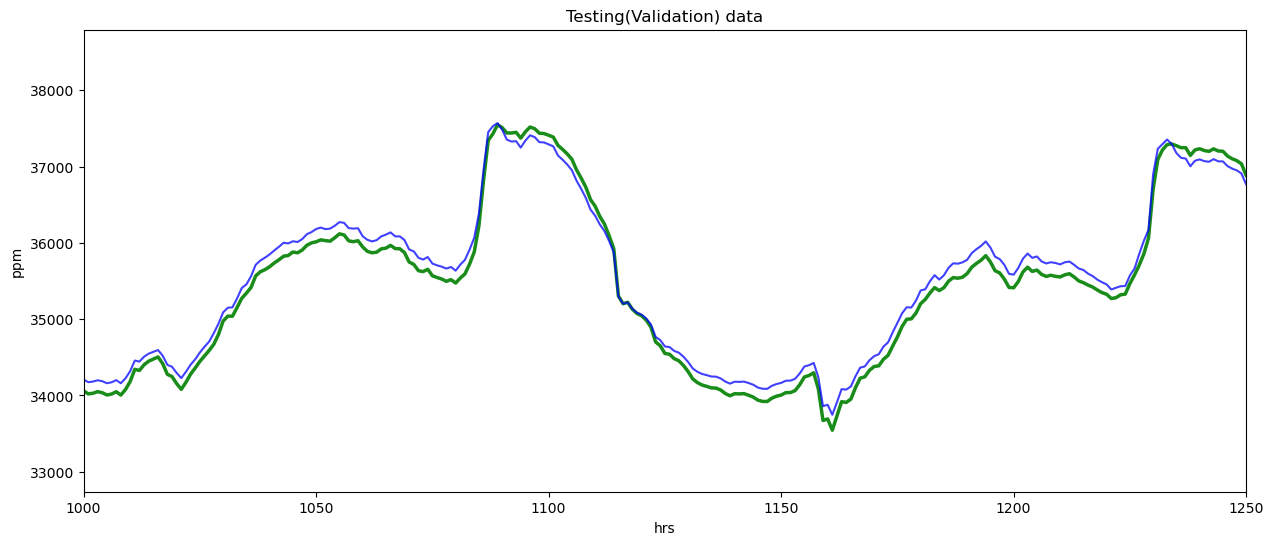

In [130]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [131]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 165.39955
MAPE: 0.4286701325327158 %
